# 0.数据来源
数据来自论文：International application of a new probability algorithm for the diagnosis of coronary artery disease.
By R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sandhu, K. Guppy, S. Lee, V. Froelicher. 1989(Published in American Journal of Cardiology)

可从此处下载：https://doi.org/10.24432/C52P4X

完整数据库共包含 76 个属性。这里使用的是其中的一个子集——**Cleveland 数据库**，**共303条，包含14个属性（包含13个特征，1个目标变量）**。


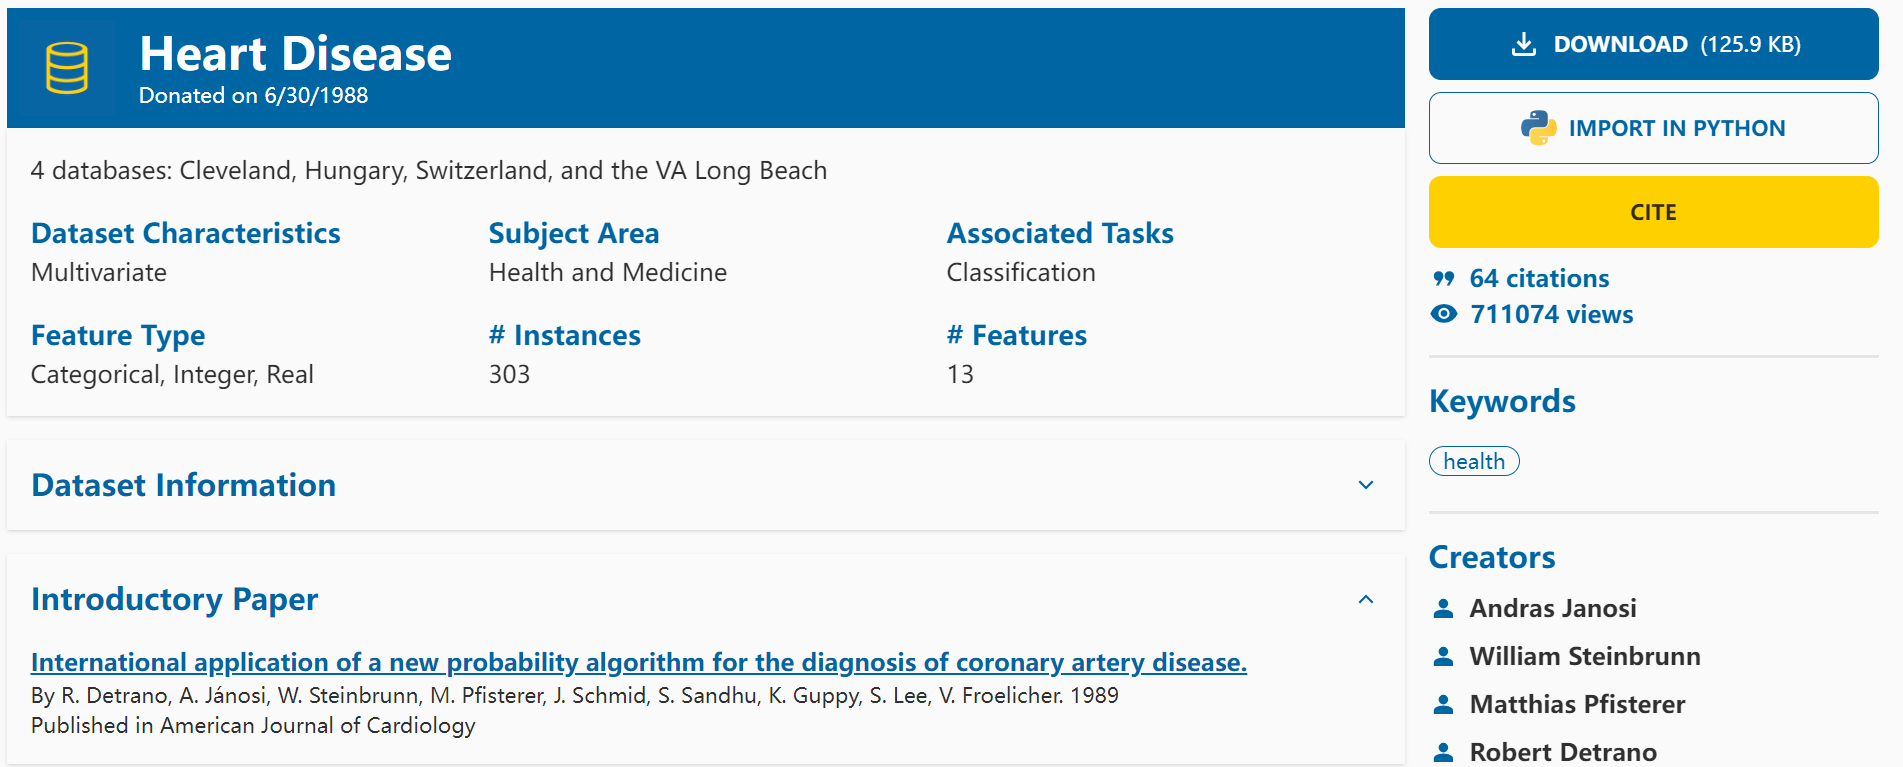

# 1.导入数据库

In [10]:
# 导入数据处理和科学计算的核心库
import numpy as np  # 数值计算库，支持高效的数组和矩阵运算
import pandas as pd  # 数据分析库，提供DataFrame等数据结构
from scipy import stats  # 统计工具包，包含各种统计检验和分布
import seaborn as sns  # 基于matplotlib的数据可视化库，提供高级绘图接口
from IPython.core.display import HTML  # 用于在Jupyter中显示HTML内容（如美化表格）
import matplotlib.pyplot as plt  # 基础绘图库，与seaborn配合使用
from scipy.stats import uniform  # 均匀分布工具，用于概率计算/随机采样

# 警告信息处理
import warnings
warnings.filterwarnings('ignore')  # 忽略所有警告提示，避免干扰输出信息

# 2.数据预处理

## 2.1 查看数据基本信息

In [12]:
# 读取数据
data = pd.read_csv(r'C:\Users\LENOVO\Desktop\Project\heart.csv')
# 打印数据维度（行数，列数）
print('Shape of the data is ', data.shape)

Shape of the data is  (303, 14)


In [14]:
# 查看前五行数据
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [16]:
# 查看每列的数据类型
data.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

### 2.1.1 特征变量说明 

- **age**: 年龄（岁）  
- **sex**: 性别  
  - `1` = 男性  
  - `0` = 女性  
- **cp**: 胸痛类型  
  - 值 `0`: 典型心绞痛  
  - 值 `1`: 非典型心绞痛  
  - 值 `2`: 非心绞痛性疼痛  
  - 值 `3`: 无症状  
- **trestbps**: 入院时的静息血压（单位：毫米汞柱）  
- **chol**: 血清胆固醇（单位：毫克/分升）  
- **fbs**: （空腹血糖 > 120 毫克/分升）  
  - `1` = 真  
  - `0` = 假  
- **restecg**: 静息心电图结果  
  - 值 `0`: 正常  
  - 值 `1`: 有 ST-T 波异常（T 波倒置和/或 ST 段升高或下降超过 0.05 毫伏）  
  - 值 `2`: 根据 Estes 标准显示可能或确诊的左心室肥大  
- **thalach**: 达到的最大心率  
- **exang**: 运动引起的心绞痛  
  - `1` = 是  
  - `0` = 否  
- **oldpeak**: 运动相对于静息引起的 ST 段下移  
- **slope**: 最大运动 ST 段的斜率  
  - 值 `0`: 上升  
  - 值 `1`: 平坦  
  - 值 `2`: 下降  
- **ca**: 通过荧光透视检查的主要血管数量（0-3）  
- **thal**:  
  - `0`: 错误（在原始数据集中，0 映射到 NaN）  
  - `1`: 固定缺陷  
  - `2`: 正常  
  - `3`: 可逆缺陷  
- **target**（标签）:  
  - `0`: 无疾病  
  - `1`: 有疾病  

### 2.1.2 目标变量说明：  
- 心脏病的诊断（血管造影疾病状态）  
  - 值 `0`: 直径狭窄 < 50%  
  - 值 `1`: 直径狭窄 > 50%  

## 2.2 数据清洗

- 数据 #93、159、164、165 和 252 的 ca=4
- 数据 #49 和 282 的 thal = 0

In [21]:
# 根据医学数据规范，'ca'（主要血管数量）正常取值范围是0-3
# 过滤掉数据集中非法的'ca'值（>=4的异常记录）
data = data[data['ca'] < 4]

# 根据医学定义，'thal'（地中海贫血检测结果）正常取值应大于0
# 过滤掉值为0的无效记录（0通常表示缺失或错误数据）
data = data[data['thal'] > 0]

print(f'经过数据清洗后，数据条数变为 {len(data)} 条，而不再是 303条了!')

经过数据清洗后，数据条数变为 296 条，而不再是 303条了!


## 2.3 数据重命名

说明：由于数据集中的列命名大多为专业名词缩略形式，不便于理解。这里重新命名列名称，
并用其医学含义替换编码类别（0、1、2等），例如将其替换为“非典型心绞痛”、“典型心绞痛”等。

In [25]:
# ================= 列名重命名：将缩写字段转为可读性更高的全称 =================
data = data.rename(
    columns = {
        'cp':'chest_pain_type',           # 胸痛类型（原缩写：cp -> chest pain）
        'trestbps':'resting_blood_pressure',  # 静息血压（原缩写：trestbps -> resting blood pressure）
        'chol': 'cholesterol',            # 胆固醇指标
        'fbs': 'fasting_blood_sugar',     # 空腹血糖（原缩写：fbs -> fasting blood sugar）
        'restecg' : 'resting_electrocardiogram',  # 静息心电图结果
        'thalach': 'max_heart_rate_achieved',  # 达到的最大心率
        'exang': 'exercise_induced_angina',     # 运动诱发心绞痛
        'oldpeak': 'st_depression',        # ST段压低值（心电图指标）
        'slope': 'st_slope',               # ST段斜率（心电图特征）
        'ca':'num_major_vessels',          # 主要血管数量（冠状动脉造影结果）
        'thal': 'thalassemia'             # 地中海贫血检测结果
    }, 
    errors="raise"  # 如果重命名时发现不存在的列名，直接报错（防止拼写错误）
)

In [27]:
# ================= 分类变量编码转换：将数值映射为可解释的文本标签 =================

# 性别（原始编码：0=女，1=男）
data['sex'][data['sex'] == 0] = 'female'  # 数值0替换为'female'
data['sex'][data['sex'] == 1] = 'male'    # 数值1替换为'male'

# 胸痛类型（临床分类）
data['chest_pain_type'][data['chest_pain_type'] == 0] = 'typical angina'     # 典型心绞痛
data['chest_pain_type'][data['chest_pain_type'] == 1] = 'atypical angina'    # 非典型心绞痛
data['chest_pain_type'][data['chest_pain_type'] == 2] = 'non-anginal pain'    # 非心绞痛性疼痛
data['chest_pain_type'][data['chest_pain_type'] == 3] = 'asymptomatic'       # 无症状

# 空腹血糖（医学阈值划分）
data['fasting_blood_sugar'][data['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'  # <120mg/dl为正常
data['fasting_blood_sugar'][data['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml' # >=120mg/dl为异常

# 静息心电图结果（临床诊断类别）
data['resting_electrocardiogram'][data['resting_electrocardiogram'] == 0] = 'normal'                   # 正常
data['resting_electrocardiogram'][data['resting_electrocardiogram'] == 1] = 'ST-T wave abnormality'    # ST-T波异常
data['resting_electrocardiogram'][data['resting_electrocardiogram'] == 2] = 'left ventricular hypertrophy'  # 左心室肥厚

# 运动诱发心绞痛（是/否判断）
data['exercise_induced_angina'][data['exercise_induced_angina'] == 0] = 'no'   # 无
data['exercise_induced_angina'][data['exercise_induced_angina'] == 1] = 'yes'  # 有

# ST段斜率（心电图特征分类）
data['st_slope'][data['st_slope'] == 0] = 'upsloping'     # 上升型
data['st_slope'][data['st_slope'] == 1] = 'flat'         # 平坦型
data['st_slope'][data['st_slope'] == 2] = 'downsloping'  # 下降型

# 地中海贫血检测结果（医学诊断类型）
data['thalassemia'][data['thalassemia'] == 1] = 'fixed defect'       # 固定缺陷
data['thalassemia'][data['thalassemia'] == 2] = 'normal'            # 正常
data['thalassemia'][data['thalassemia'] == 3] = 'reversable defect' # 可逆缺陷

In [29]:
# ================= 数据验证 =================
data.dtypes  # 检查数据类型是否因标签替换而改变（例如是否意外转换为object类型）

age                            int64
sex                           object
chest_pain_type               object
resting_blood_pressure         int64
cholesterol                    int64
fasting_blood_sugar           object
resting_electrocardiogram     object
max_heart_rate_achieved        int64
exercise_induced_angina       object
st_depression                float64
st_slope                      object
num_major_vessels              int64
thalassemia                   object
target                         int64
dtype: object

In [31]:
data.head()  # 查看前5行数据，确认列名和值替换是否成功

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiogram,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,male,asymptomatic,145,233,greater than 120mg/ml,normal,150,no,2.3,upsloping,0,fixed defect,1
1,37,male,non-anginal pain,130,250,lower than 120mg/ml,ST-T wave abnormality,187,no,3.5,upsloping,0,normal,1
2,41,female,atypical angina,130,204,lower than 120mg/ml,normal,172,no,1.4,downsloping,0,normal,1
3,56,male,atypical angina,120,236,lower than 120mg/ml,ST-T wave abnormality,178,no,0.8,downsloping,0,normal,1
4,57,female,typical angina,120,354,lower than 120mg/ml,ST-T wave abnormality,163,yes,0.6,downsloping,0,normal,1


## 2.4 特征分类

In [34]:
# ================= 特征分类：按数据类型和业务意义分组 =================
# 根据数据探索阶段的分析（data.dtypes），将特征分为三种类型处理：
# 1. 数值型特征（连续或离散数值） | 2. 二分类特征 | 3. 多分类特征

# --- 数值型特征(Numerical Features)  （6个） ---
# 适用于标准化/归一化、分布分析、回归系数解读等操作
num_feats = [
    'age',                 # 年龄（整数，连续型）
    'cholesterol',         # 胆固醇指标（连续型）
    'resting_blood_pressure',  # 静息血压（连续型）
    'max_heart_rate_achieved', # 达到的最大心率（离散型，整数）
    'st_depression',       # ST段压低值（连续型，心电图指标）
    'num_major_vessels'    # 主要血管数量（离散型，0-3）
]

# --- 二分类特征(Binary Categorical Features)  （除去目标变量target，共3个二分类特征） ---
# 适用于布尔编码（0/1 或 yes/no）
bin_feats = [
    'sex',                    # 性别（'female'/'male' → 通常编码为0/1）
    'fasting_blood_sugar',    # 空腹血糖（分类标签已转换为文本）
    'exercise_induced_angina',# 运动诱发心绞痛（'no'/'yes'）
    'target'                  # 目标变量（0=无心脏病，1=有心脏病）
]

# --- 多分类特征(Multiclass Categorical Features) （4个） ---
# 适用于独热编码（One-Hot Encoding），因无序类别无法直接数值化
nom_feats = [
    'chest_pain_type',          # 胸痛类型（4个类别，如典型心绞痛）
    'resting_electrocardiogram',# 静息心电图结果（3个类别）
    'st_slope',                # ST段斜率（3个类别：上升/平坦/下降）
    'thalassemia'              # 地中海贫血类型（3个类别）
]

# --- 合并所有分类特征 ---
# 用于统一处理分类变量的编码（如独热编码或标签编码）
cat_feats = nom_feats + bin_feats 

# 3.探索性数据分析（EDA）

## 3.1 目标变量分析

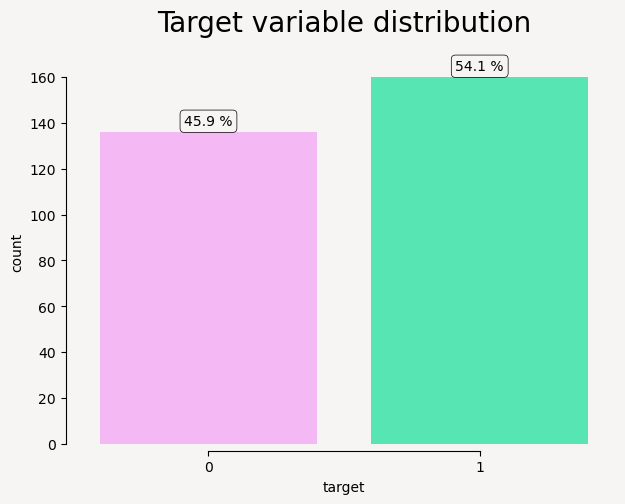

In [38]:
# 自定义颜色调色板（6种颜色，从粉色到绿色渐变）
mypal= ['#FC05FB', '#FEAEFE', '#FCD2FC','#F3FEFA', '#B4FFE4','#3FFEBA']

# 创建画布，设置图形参数
plt.figure(figsize=(7, 5), facecolor='#F6F5F4')  # 图形尺寸7x5英寸，背景色为浅灰色

# 绘制目标变量分布柱状图
ax = sns.countplot(
    x=data['target'],  # 使用target列数据
    palette=mypal[1::4]  # 颜色从mypal列表中选择第2个和第6个颜色（索引1和5）
)
ax.set_facecolor('#F6F5F4')  # 设置绘图区背景色与画布一致

# 添加百分比标签
total = float(len(data))  # 计算总样本数
for p in ax.patches:      # 遍历每个柱形
    height = p.get_height()  # 获取柱形高度（计数）
    # 在柱形顶部中央位置添加文本：计算百分比并格式化显示
    ax.text(
        x=p.get_x() + p.get_width()/2.,  # X轴位置：柱形中心
        y=height + 3,                    # Y轴位置：柱形高度上方3个单位
        s='{:1.1f} %'.format((height/total)*100),  # 显示百分比（保留1位小数）
        ha="center",                     # 水平居中
        bbox=dict(                       # 文本边框样式
            facecolor='none',             # 透明背景
            edgecolor='black',            # 黑色边框
            boxstyle='round',             # 圆角矩形
            linewidth=0.5                 # 边框线宽
        )
    )

# 设置标题和图形修饰
ax.set_title('Target variable distribution', fontsize=20, y=1.05)  # 标题字体20pt，垂直位置提升5%
sns.despine(right=True)    # 移除右侧坐标轴线
sns.despine(offset=5, trim=True)  # 左侧/底部坐标轴偏移5pt，并修剪超出数据范围的部分

由上图，数据平衡性：无疾病（46%） vs 有疾病（54%）

通常认为40%-60%属于平衡数据集，**故无需进行过采样/欠采样**

## 3.2 数值型特征【Numerical Features】（6个）分析

对“2.4特征分类”中的6个“数值型特征”可使用 Pandas 的 `data.describe()` 方法生成全局统计摘要

In [43]:
data[num_feats].describe().T

,count,mean,std,min,25%,50%,75%,max
age,296.0,54.523649,9.059471,29.0,48.0,56.0,61.00,77.0
cholesterol,296.0,247.155405,51.977011,126.0,211.0,242.5,275.25,564.0
resting_blood_pressure,296.0,131.604730,17.726620,94.0,120.0,130.0,140.00,200.0
max_heart_rate_achieved,296.0,149.560811,22.970792,71.0,133.0,152.5,166.00,202.0
st_depression,296.0,1.059122,1.166474,0.0,0.0,0.8,1.65,6.2
num_major_vessels,296.0,0.679054,0.939726,0.0,0.0,0.0,1.00,3.0


根据上表，对“数值型特征”的统计结果总结如下： 
| 特征                                 | 平均值                     | 极值分布                          |  
|------------------------------------|-------------------------|---------------------------------|  
| **年龄（Age）**                     | 54.5 岁                 | 最年长者 77 岁 / 最年轻者 29 岁        |  
| **胆固醇（Cholesterol）**             | 247.15 mg/dl           | 最高值 564 mg/dl / 最低值 126 mg/dl   |  
| **静息血压（Resting Blood Pressure）** | 131 mmHg                | 最高 200 mmHg / 最低 94 mmHg         |  
| **最大心率（Max Heart Rate Achieved）** | 149.5 bpm              | 最高 202 bpm / 最低 71 bpm           |  
| **ST段压低值（ST_depression）**         | 1.06                    | 最大 6.2 / 最小 0                    |  
| **主要血管数量（Number of Major Blood Vessels）** | 0.68 条               | 最多 3 条 / 最少 0 条                  |  

### 3.2.1 单变量分布特征可视化——密度图(Density plot)、计数图(countplot)

**可视化目标** ：分析**单个特征**在**不同目标类别**中的分布差异<br>
**主要图表类型**：
<br>-密度曲线（连续变量）<br> -柱状计数图（离散变量）

即：除“num_major_vessels”（血管数量特征）外，其余5个特征值都作密度图；

而num_major_vessels因为是离散型数值（0-3个血管），更适合用柱状图计数

Text(0.5, 0.98, 'Distribution of Numerical Features')

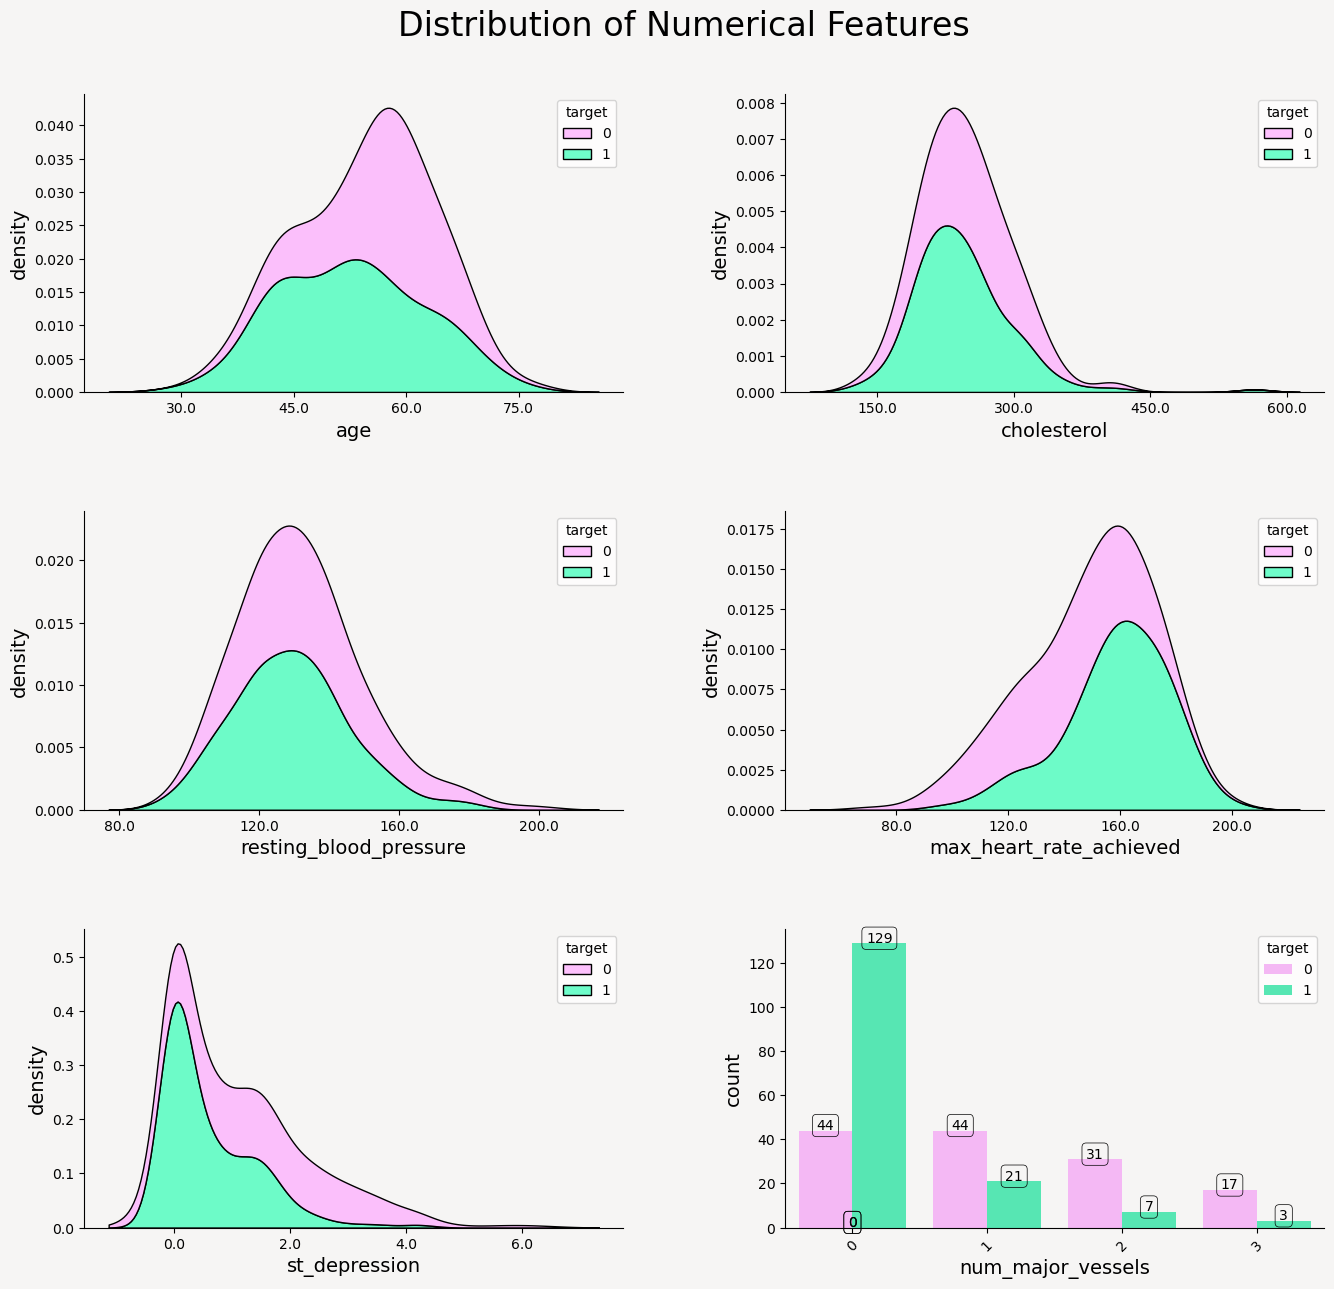

In [48]:
# ================= 数值特征分布可视化：密度图与计数图混合 =================

from matplotlib.ticker import FormatStrFormatter, MaxNLocator  # 💡 新增导入
# 设置子图布局参数
L = len(num_feats)  # 数值特征数量（6个）
ncol = 2            # 每行显示2个子图
nrow = int(np.ceil(L/ncol))  # 计算需要的行数（ceil(6/2)=3行）

# 创建画布（背景色#F6F5F4浅灰）
fig, axs = plt.subplots(nrow, ncol, figsize=(16,14), facecolor='#F6F5F4')
axs = axs.flatten()  # 💡将子图数组展平为一维，便于循环访问
fig.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3)  # 💡增加子图间距

# 循环绘制每个数值特征
for i, col in enumerate(num_feats):
    ax = axs[i]  # 💡通过索引直接获取当前子图对象
    ax.set_facecolor('#F6F5F4')  # 设置当前子图背景色
    
    # 对多数特征绘制堆叠密度图 --------------------------------------------------
    if col != 'num_major_vessels':
        # 创建KDE密度图（按target分层堆叠）
        sns.kdeplot(
            data=data, 
            x=col, 
            hue="target", 
            multiple="stack",  # 堆叠显示不同类别
            palette=mypal[1::4],  # 使用自定义颜色（索引1和5的粉色/绿色）
            ax=ax  # 💡直接使用当前子图对象
        )
        
        # 设置轴标签样式
        ax.set_xlabel(col, fontsize=14)  # X轴标签（特征名），💡缩小字体
        ax.set_ylabel("density", fontsize=14)  # Y轴标签
        
        # 修饰坐标轴
        sns.despine(right=True)  # 移除右侧框线
        sns.despine(offset=0, trim=False)  # 取消默认轴偏移

        # 💡统一连续变量刻度格式
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f')) 
        ax.xaxis.set_major_locator(MaxNLocator(5))  # 最多显示5个刻度

    # 对血管数量特征特殊处理：绘制计数直方图 --------------------------------------
    else:
        # 因为血管数量是离散值（0-3），更适合用计数图
        sns.countplot(
            data=data, 
            x=col, 
            hue="target", 
            palette=mypal[1::4],
            ax=ax  # 💡直接使用当前子图对象
        )
        
        # 💡修复标签：重新添加计数标签
        for p in ax.patches:
            height = p.get_height()  # 获取柱高
            ax.text(
                p.get_x() + p.get_width()/2.,  # X坐标居中
                height + 0.5,  # 💡Y坐标微调，避免重叠
                f'{height:.0f}',  # 显示整数计数
                ha="center",
                fontsize=10,  # 💡缩小标签字体
                bbox=dict(
                    facecolor='none', 
                    edgecolor='black', 
                    boxstyle='round', 
                    linewidth=0.5
                )
            )
        
        # 💡设置离散刻度标签
        ax.set_xticks([0,1,2,3])
        ax.set_xticklabels(['0','1','2','3'], rotation=45)
        ax.set_xlabel(col, fontsize=14)
        ax.set_ylabel("count", fontsize=14)  # 💡修正Y轴标签

# 💡隐藏多余子图（当特征数不足填满所有子图时）
for j in range(len(num_feats), nrow*ncol):
    axs[j].axis('off')

# 添加总标题
plt.suptitle('Distribution of Numerical Features', fontsize=24)

### 3.2.2 双变量相关性可视化——散点图矩阵(Pair-plots)、回归图(regplot)

**可视化目标** ：探索**多个特征之间的相互关系**及联合分布模式<br>
**主要图表类型**：
<br>- 散点图（两变量关系）<br>- 直方图（单变量分布）

Text(0.5, 1.02, 'Pairplot: Numerical Features')

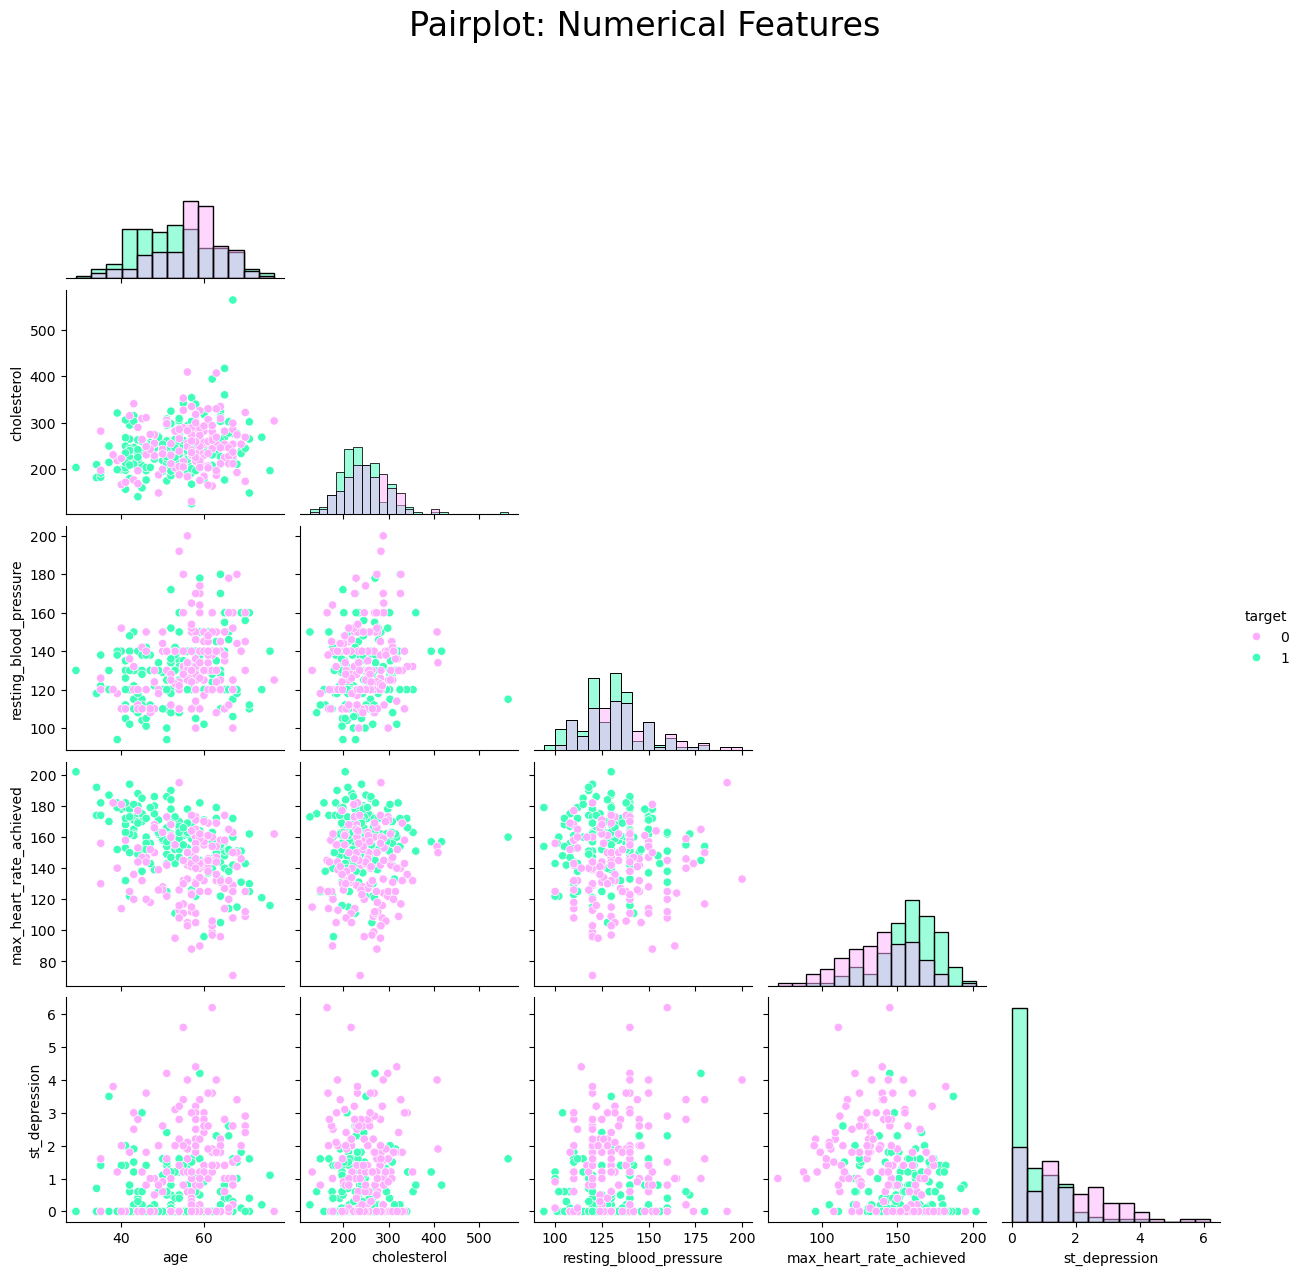

In [52]:
# ================= 数值特征关系矩阵图（Pairplot） =================

# 筛选需要分析的数值特征（含目标变量）
_ = [
    'age',                      # 年龄
    'cholesterol',              # 胆固醇
    'resting_blood_pressure',   # 静息血压
    'max_heart_rate_achieved',  # 最大心率
    'st_depression',            # ST段压低值
    'target'                    # 目标变量（心脏病诊断结果）
]

# 从原始数据中提取选定列
data_ = data[_]

# 创建配对图矩阵
g = sns.pairplot(
    data=data_, 
    hue="target",             # 按目标变量分类着色
    corner=True,              # 只显示下三角矩阵（避免重复图形）
    diag_kind='hist',         # 对角线显示直方图（替代默认的KDE）
    palette=mypal[1::4]       # 使用粉色/绿色分类配色（与之前可视化保持一致）
)

# 设置总标题（可能需要调整位置避免重叠）
plt.suptitle('Pairplot: Numerical Features', fontsize=24, y=1.02)  # y参数微调垂直位置

对上面散点图矩阵的**第1列**（即：年龄与胆固醇、最大心率、静息血压、ST段低压值的散点图），再叠加做一个回归分析图，以此来**分析“年龄”特征与其他4个特征间的回归关系**

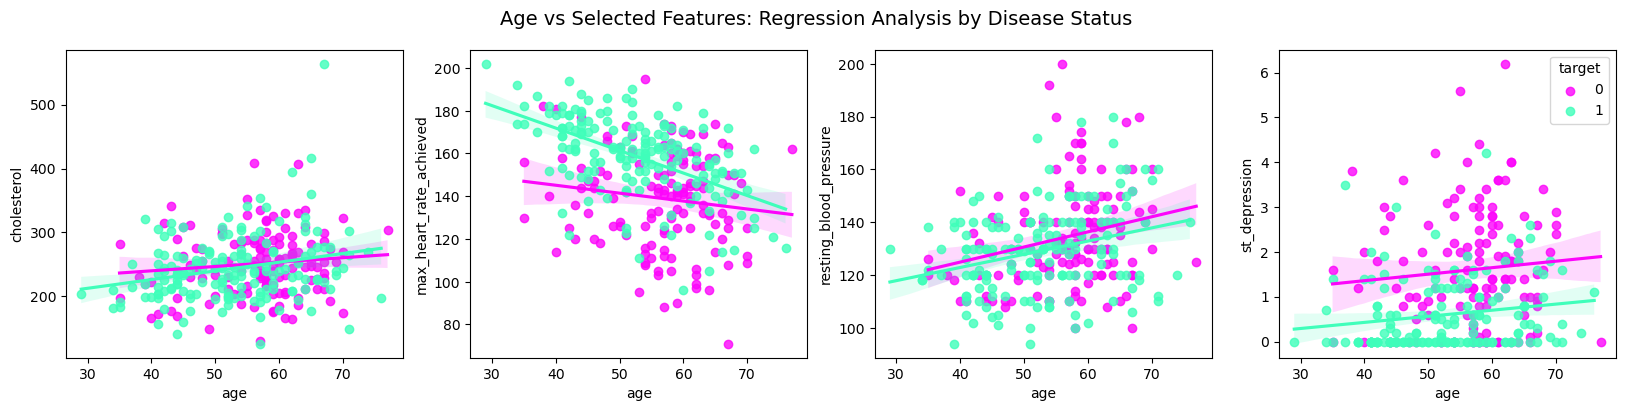

In [55]:
# ================= 选定“年龄”特征进行回归分析 =================

# 创建1行4列的子图布局，画布尺寸20x4英寸
fig, ax = plt.subplots(1,4, figsize=(20, 4))

# --- 特征1：胆固醇 vs 年龄 ---
# 叠加健康组（target=0）回归图，使用粉色（mypal[0]）
sns.regplot(
    data=data[data['target'] ==0], 
    x='age', y='cholesterol', 
    ax=ax[0], color=mypal[0], label='0'
)
# 绘制患病组（target=1）回归图，使用绿色（mypal[5]）
sns.regplot(
    data=data[data['target'] ==1], 
    x='age', y='cholesterol', 
    ax=ax[0], color=mypal[5], label='1'
)

# --- 特征2：最大心率 vs 年龄 ---
sns.regplot(data=data[data['target'] ==0], x='age', y='max_heart_rate_achieved', ax=ax[1], color=mypal[0], label='0')
sns.regplot(data=data[data['target'] ==1], x='age', y='max_heart_rate_achieved', ax=ax[1], color=mypal[5], label='1')
# --- 特征3：静息血压 vs 年龄 ---
sns.regplot(data=data[data['target'] ==0], x='age', y='resting_blood_pressure', ax=ax[2], color=mypal[0], label='0')
sns.regplot(data=data[data['target'] ==1], x='age', y='resting_blood_pressure', ax=ax[2], color=mypal[5], label='1')
# --- 特征4：ST段压低值 vs 年龄 ---
sns.regplot(data=data[data['target'] ==0], x='age', y='st_depression', ax=ax[3], color=mypal[0], label='0')
sns.regplot(data=data[data['target'] ==1], x='age', y='st_depression', ax=ax[3], color=mypal[5], label='1')
# 设置总标题和图例
plt.suptitle('Age vs Selected Features: Regression Analysis by Disease Status', fontsize=14)
plt.legend(title='target', bbox_to_anchor=(1, 1))  # 图例放置在右侧

解读：
1. **图表核心发现**

   | 特征           | 患病组趋势   | 健康组趋势   | 医学意义洞察                         |
   | :------------- | :----------- | :----------- | :----------------------------------- |
   | **胆固醇**     | 显著正相关 ↗️ | 正相关 ↗️     | 年龄增长导致胆固醇升高，患病组更显著 |
   | **最大心率**   | 明显负相关 ↘️ | 微弱负相关 ↘️ | 年轻患者高心率更易患病               |
   | **静息血压**   | 正相关 ↗️     | 正相关 ↗️     | 年龄相关血压升高无显著组间差异       |
   | **ST段压低值** | 微弱正相关 ↗️ | 基本无关联 ➡️ | 低ST值可能预示患病，与年龄无关       |

2. **置信区间解读**

   - 灰色阴影带表示95%置信区间
   - 阴影带越窄，回归线可靠性越高（如胆固醇图）
   - ST段压低值的宽置信区间表明数据离散度高，需谨慎解读
3. 综上，绘制了四个回归图，分别展示了胆固醇、最大心率、静息血压和ST段压低值与年龄的关系。观察结果是除了最大心率外，其他特征与年龄呈正相关，尽管ST段压低的相关性较弱。同时，年轻患者最大心率较高可能更易患心脏病，而ST段压低值较低可能也是心脏病的指标。

## 3.3 分类型特征【caterorical (binary&multi)】(3+4个)分析

对“2.4特征分类”中的7个“分类型特征”进行分析<br>
通过计数图可视化各分类型特征与目标变量（患病=1/健康=0）的关系，重点关注以下两方面：<br>
- 各分类型特征在数据集中的分布情况<br>
- 各分类型特征对目标变量预测概率的贡献度

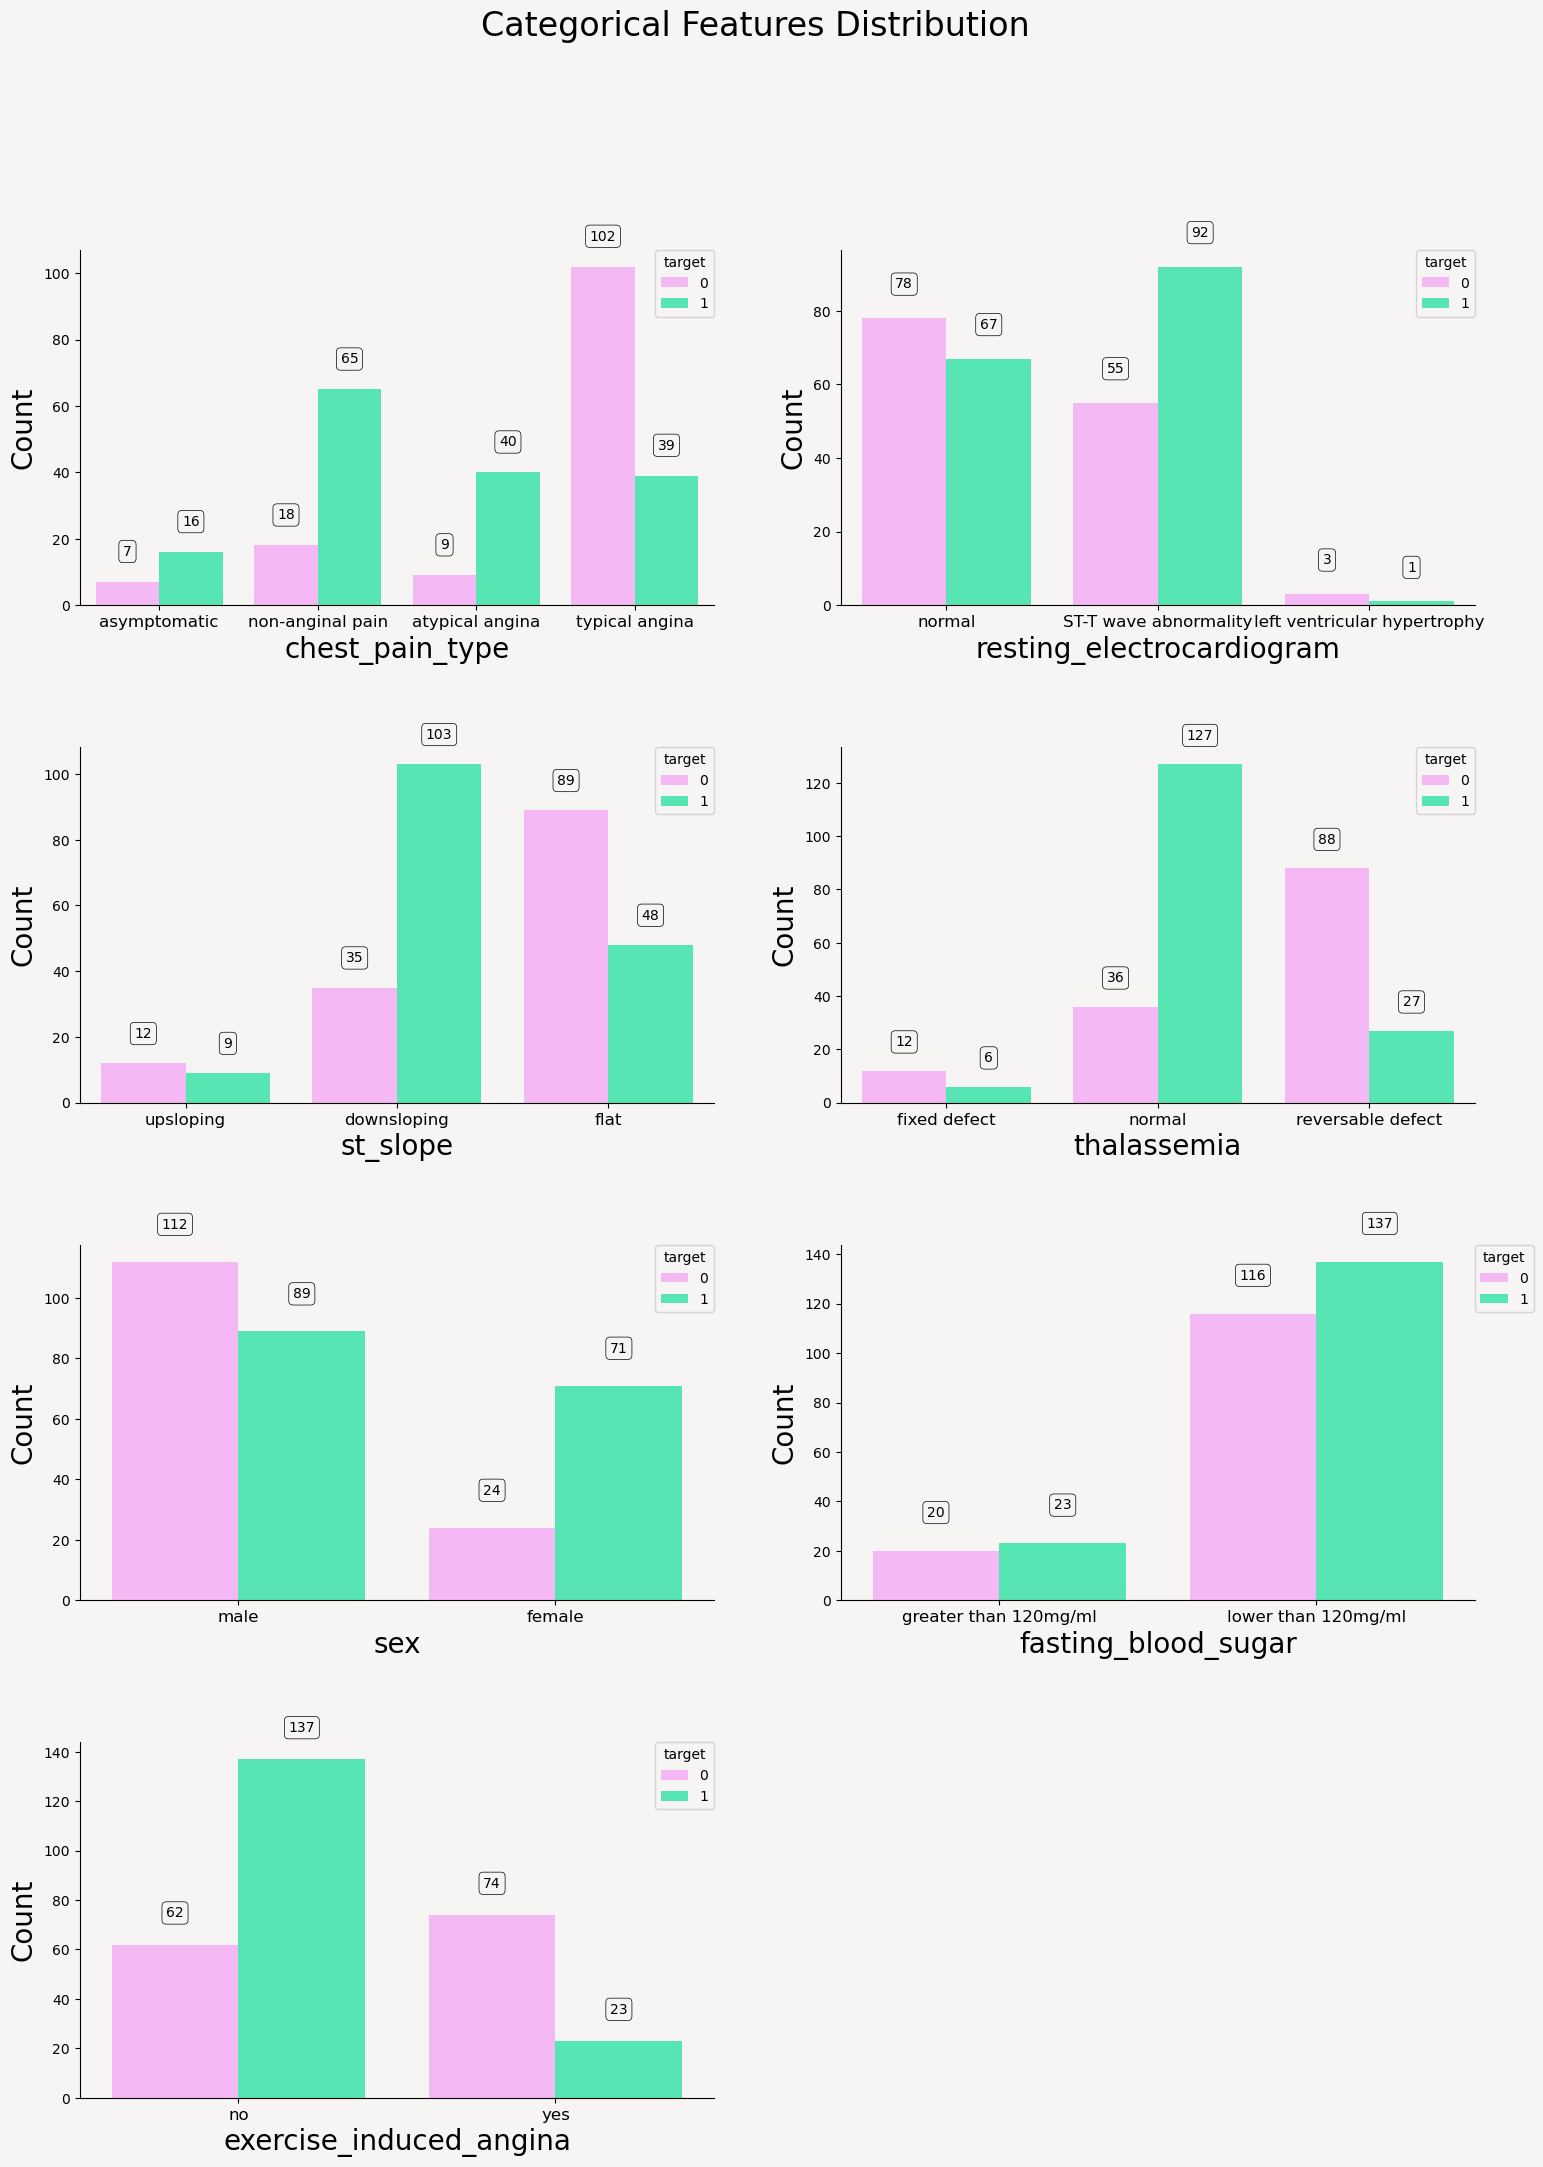

In [60]:
def count_plot(data, cat_feats):
    # 计算图表行列布局
    L = len(cat_feats)  # 获取分类特征数量
    ncol = 2  # 每行显示2个子图
    nrow = int(np.ceil(L/ncol))  # 计算所需行数
    remove_last = (nrow * ncol) - L  # 需要隐藏的空白子图数

    # 初始化画布
    fig, axs = plt.subplots(
        nrow, ncol,
        figsize=(18, 24),  # 设置画布尺寸
        facecolor='#F6F5F4',  # 画布背景色
        gridspec_kw={'hspace': 0.4, 'wspace': 0.2}  # 子图间距设置
    )
    axs = axs.flatten()  # 将多维轴数组转为一维

    # 隐藏空白子图
    for j in range(L, nrow*ncol):
        axs[j].axis('off')

    # 遍历每个分类特征绘制图表
    for i, col in enumerate(cat_feats):
        ax = axs[i]  # 获取当前子图对象
        ax.set_facecolor('#F6F5F4')  # 设置子图背景色

        # 数据预处理
        valid_values = data[col][data[col] != 0].unique()  # 过滤0值
        
        # 绘制分类分布图
        sns.countplot(
            data=data[data[col].isin(valid_values)],  # 过滤无效数据
            x=col,
            hue="target",
            palette=mypal[1::4],  # 使用预设配色方案
            order=valid_values,  # 指定类别显示顺序
            ax=ax
        )

        # 设置坐标轴标签
        ax.set_xlabel(col, fontsize=20)  # X轴标签（特征名称）
        ax.set_ylabel("Count", fontsize=20)  # Y轴标签（计数）
        
        # 设置刻度标签
        ax.set_xticklabels(
            [str(x) for x in valid_values],  # 转换为字符串避免格式问题
            fontsize=12  # 调小标签字号
        )

        # 添加数值标签
        max_count = data[col].value_counts().max()  # 获取最大计数值
        for p in ax.patches:
            if p.get_height() > 0:  # 过滤空值柱形
                ax.text(
                    p.get_x() + p.get_width()/2,  # X轴居中位置
                    p.get_height() + max_count*0.05,  # Y轴动态偏移
                    f'{p.get_height():.0f}',  # 显示整数值
                    ha='center',  # 水平居中
                    va='bottom',  # 垂直底部对齐
                    fontsize=10,  # 标签字号
                    bbox=dict(  # 文字边框样式
                        facecolor='none',
                        edgecolor='black',
                        boxstyle='round',
                        linewidth=0.5
                    )
                )

        # 设置图例
        ax.legend(
            title='target',
            labels=['0', '1'],  # 图例标签
            facecolor='#F6F5F4',  # 图例背景色
            bbox_to_anchor=(1, 1),  # 图例外置坐标
            borderaxespad=0  # 图例边距
        )

        # 移除顶部和右侧边框
        sns.despine(top=True, right=True, ax=ax)  # 核心修改点

    # 设置全局标题
    plt.suptitle(
        'Categorical Features Distribution',
        fontsize=24,
        y=0.98  # 标题垂直位置
    )
    
    return fig  # 返回图表对象

# 执行绘图函数
fig = count_plot(data, cat_feats[0:-1])
plt.show()

由上图，可得如下分析结果：
| 特征                     | 分布特征                                                                 | 疾病关联                                       |  
|------------------------|---------------------------------------------------------------------|---------------------------------------------|  
| **胸痛类型 (Chest Pain)**     | 超过 75% 患者表现为典型心绞痛或非心绞痛性胸痛                                   | 非典型心绞痛/非心绞痛性胸痛患者患病率更高                |  
| **静息心电图 (Resting Electrocardiogram)** | 左心室肥厚患者最少（约 1.4%）<br>ST-T 波异常与正常检测结果患者比例接近 1:1 | ST-T 波异常患者确诊心脏病比例显著更高                  |  
| **ST段斜率 (ST-Slope)**         | 多数患者呈现下降型或平坦型 ST 段斜率                                         | 下降型 ST 段斜率是心脏病的重要预测指标               |  
| **地中海贫血 (Thalassemia)**    | 多数患者检测结果正常或呈可逆性缺陷                                          | 异常结果（可逆 + 固定缺陷）患者患病率更低              |  
| **空腹血糖 (Fasting Blood Sugar)**    | 85% 患者空腹血糖 < 120 mg/ml                                         | 低血糖患者患病概率更高（约 54%）                   |  
| **运动诱发心绞痛 (Exercise Induced Angina)** | 2/3 患者无运动诱发心绞痛                                             | 有症状患者 76% 未患病<br>无症状患者 69% 确诊患病      |  
| **性别 (Sex)**                 | 样本中男性患者居多                                                    | 女性患者患病比例高于男性（需考虑样本偏差）             |  

## 3.4 相关性热图

**相关分析**主要分为简单相关(simple correlation)分析、偏相关(partial correlation)分析和距离相关(distance correlation)分析。

**相关性热图**是用于可视化展示两个特征之间关系的有效工具。根据特征的数据类型，需要使用适当的相关系数计算方法。
下面采用三种相关系数计算方法做热图：
- **皮尔逊相关系数（pearson's correlation coefficient）**【用于数据中6个数值型特征间的相关性分析】
- **点二列相关系数（point biserial correlation）**（见教材《环境数据分析（第二版）》 例2-2）【用于数据中6个数值型特征与目标变量的相关性分析】
- **克莱姆V相关系数（cramers'V correlation）**【用于数据中7个分类型特征间的相关性分析】

### 3.4.1 皮尔逊相关（Pearson's correlation）分析

皮尔逊相关系数是衡量两组数据之间线性相关性的指标。它是两个变量协方差与它们标准差的乘积之比，本质上是对协方差的标准化测量，其结果始终在-1到1之间。

下面对 **2.4特征分类”中的6个数值型特征** 进行皮尔逊相关分析

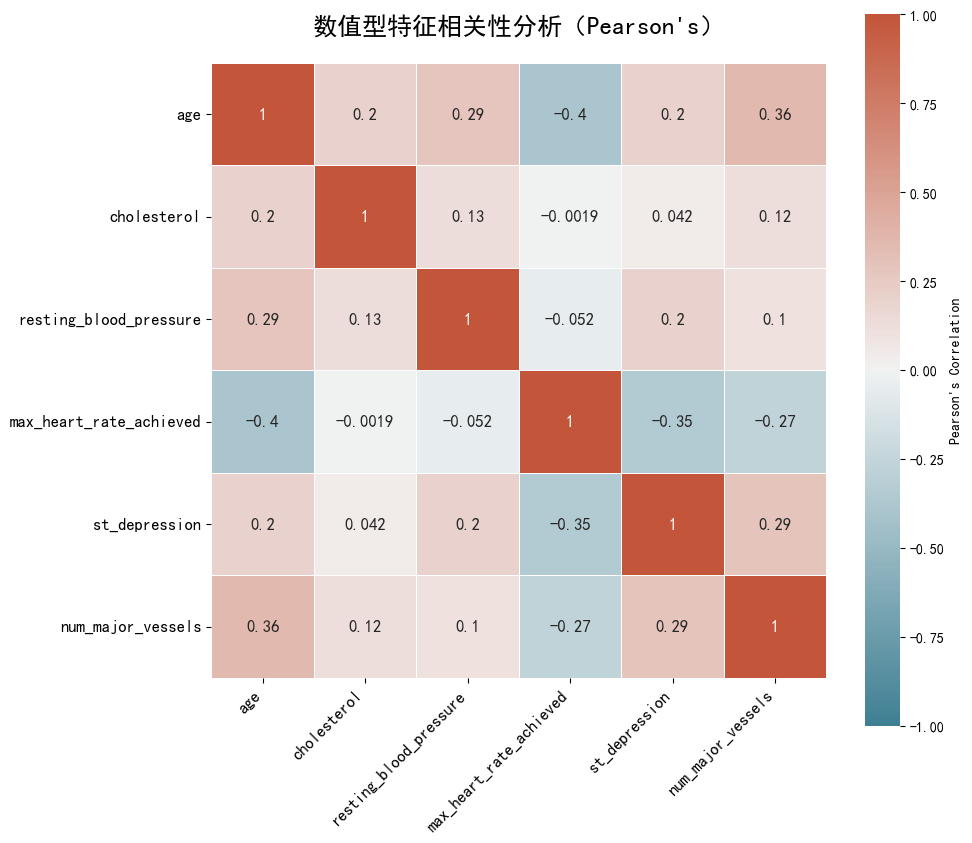

In [67]:
# 新增代码：设置中文字体并解决符号显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统常用黑体
plt.rcParams['axes.unicode_minus'] = False
# 选择数值型特征
df_ = data[num_feats]
# 计算皮尔逊相关系数矩阵
corr = df_.corr(method='pearson')
# 创建正方形画布
plt.figure(figsize=(10, 10))  # 等宽等高
cmap = sns.diverging_palette(220, 20, as_cmap=True)  # 经典红蓝渐变
# 绘制完整热力图
ax = sns.heatmap(
    corr,
    cmap=cmap,          # 经典配色
    vmin=-1, vmax=1,     # 固定颜色范围
    center=0,            # 白对应0值
    annot=True,          # 显示数值
    annot_kws={"size": 12},  # 标注字号
    square=True,         # 单元格强制为正方形
    linewidths=0.5,      # 单元格边框
    linecolor='white',   # 边框颜色
    cbar_kws={
        "shrink": 0.8,   # 颜色条尺寸
        "label": "Pearson's Correlation"  # 颜色条标签
    }
)
# 设置标签和标题
ax.set_xticks(np.arange(len(corr.columns)) + 0.5)
ax.set_yticks(np.arange(len(corr.columns)) + 0.5)
ax.set_xticklabels(corr.columns, rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(corr.columns, rotation=0, fontsize=12)
plt.title("数值型特征相关性分析（Pearson's）", 
         fontsize=18, pad=20)
# 添加网格线（可选）
ax.grid(which='minor', color='white', linestyle='-', linewidth=2)
plt.tight_layout()
plt.show()

上面的数值型特征相关性分析（Pearson‘s）显示，6个数值型特征的Pearson’s相关系数均小于0.4

根据“相关系数与相关程度对应表”（《环境数据分析（第二版）》6.2.2 表6-1）

| 相关系数         | 相关程度   |  
|------------------|------------|  
| 0.0  < r < 0.2   | 不相关     |  
| 0.2  < r < 0.4   | 弱相关     |  
| 0.4  < r < 0.6   | 中度相关   |  
| 0.6  < r < 0.8   | 强相关     |  
| 0.8  < r < 1.0   | 极强相关   |  
    
可知：**数值型特征间相关性普遍较弱**。由于相关系数也均小于0.7，故**预测变量间不存在多重共线性**。

### 3.4.2 点二列相关（Point biserial correlation）分析

点二列相关系数用于衡量一个**连续变量**与一个**二分类变量**之间的关联强度和方向。这是皮尔逊积矩相关系数的**特殊形式**，
当两个变量均为连续变量时使用标准皮尔逊系数，而点二列相关**适用于其中一个变量为二分类的情况**

下面对 **2.4特征分类中的6个数值型特征** 与**目标变量**进行点二列相关分析

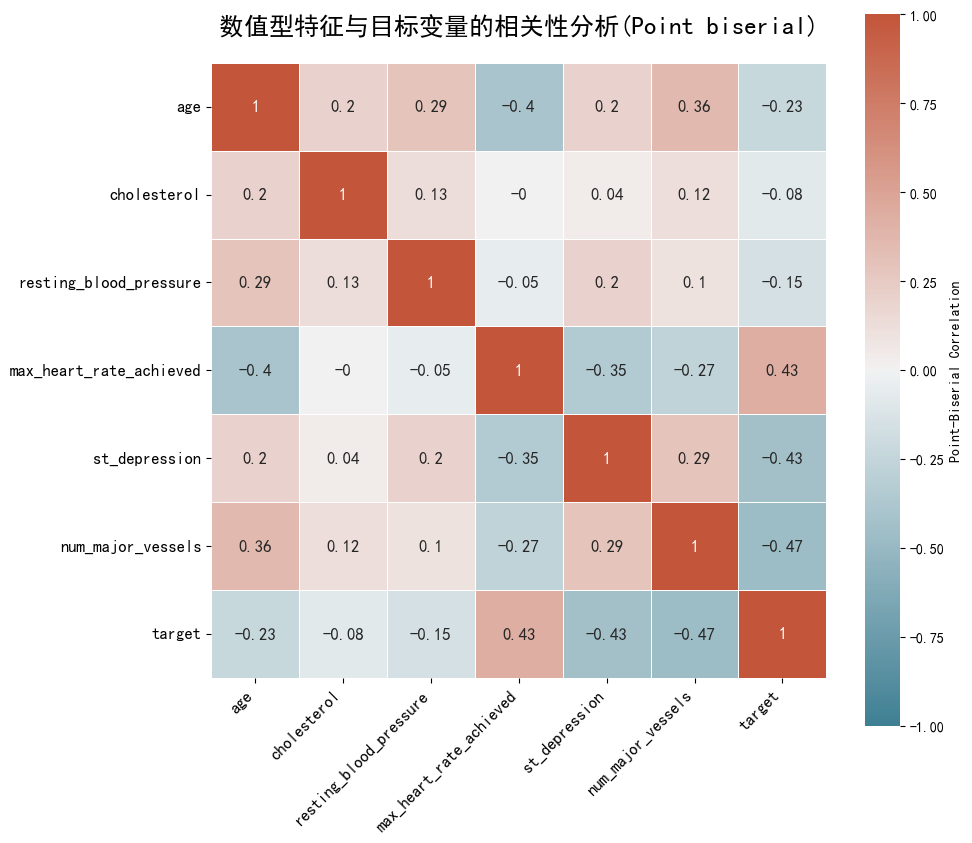

In [69]:
plt.rcParams['axes.unicode_minus'] = False
# 定义待分析特征列
feats_ = ['age', 'cholesterol', 'resting_blood_pressure', 
         'max_heart_rate_achieved', 'st_depression', 
         'num_major_vessels', 'target']
# 定义点二列相关系数计算函数
def point_biserial(x, y):
    # 使用scipy的统计方法计算
    pb = stats.pointbiserialr(x, y)
    # 返回保留两位小数的相关系数
    return round(pb[0], 2)
# 初始化结果存储矩阵
corr_matrix = []
# 遍历所有特征对进行计算
for col1 in feats_:
    row = []
    for col2 in feats_:
        # 计算每对特征的点二列相关系数
        coeff = point_biserial(data[col1], data[col2])
        row.append(coeff)
    corr_matrix.append(row)
# 转换为DataFrame格式
corr_df = pd.DataFrame(
    corr_matrix,
    columns=data[feats_].columns,
    index=data[feats_].columns
)
# 创建正方形画布
plt.figure(figsize=(10, 10))
# 设置经典红蓝配色方案
cmap = sns.diverging_palette(220, 20, as_cmap=True)
# 绘制完整热力图
ax = sns.heatmap(
    corr_df, 
    cmap=cmap,          # 经典红蓝渐变
    vmin=-1, vmax=1,    # 固定颜色范围
    center=0,            # 白色对应零相关
    annot=True,          # 显示数值标签
    annot_kws={"size": 12},  # 标签字号
    square=True,         # 单元格保持正方形
    linewidths=0.5,      # 单元格边框宽度
    linecolor='white',   # 边框颜色
    cbar_kws={
        "shrink": 0.8,   # 颜色条缩放比例
        "label": "Point-Biserial Correlation"  # 颜色条标题
    }
)
# 设置坐标轴标签
ax.set_xticks(np.arange(len(corr_df.columns)) + 0.5)
ax.set_yticks(np.arange(len(corr_df.columns)) + 0.5)
ax.set_xticklabels(
    corr_df.columns,
    rotation=45,         # X轴标签45度旋转
    ha='right',          # 右对齐
    fontsize=12
)
ax.set_yticklabels(
    corr_df.columns,
    rotation=0,          # Y轴标签不旋转
    fontsize=12
)
# 设置主标题
plt.title(
    "数值型特征与目标变量的相关性分析(Point biserial)", 
    fontsize=18, 
    pad=20  # 标题下间距
)

# 优化布局显示
plt.tight_layout()

在6个数值型特征中，**主要血管数量（num_major_vessels）、最大心率（max_heart_rate_achieved）和 ST 段压低值（st_depression）** 与目标变量的相关性较大，**相关系数分别为 -0.47、0.43 和 -0.43**，呈现出合理的相关性。

有点反常识的发现是**胆固醇（Cholestrol）竟然与目标变量几乎不存在相关性！！！！** 这是数据问题造成的吗？？或许还需要阅读些医学领域的相关文献才能解决这个问题。

### 3.4.3 克莱姆V相关（Cramer's V correlation）分析

在统计学中，克莱姆V（Cramér’s V）是衡量两个分类型变量之间关联程度的指标，其值域为0到1（含）。该系数基于皮尔逊卡方统计量，由Harald Cramér于1946年提出。具体原理详见：维基百科https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

下面对**2.4特征分类**中的**7个分类型特征**进行克莱姆V相关分析

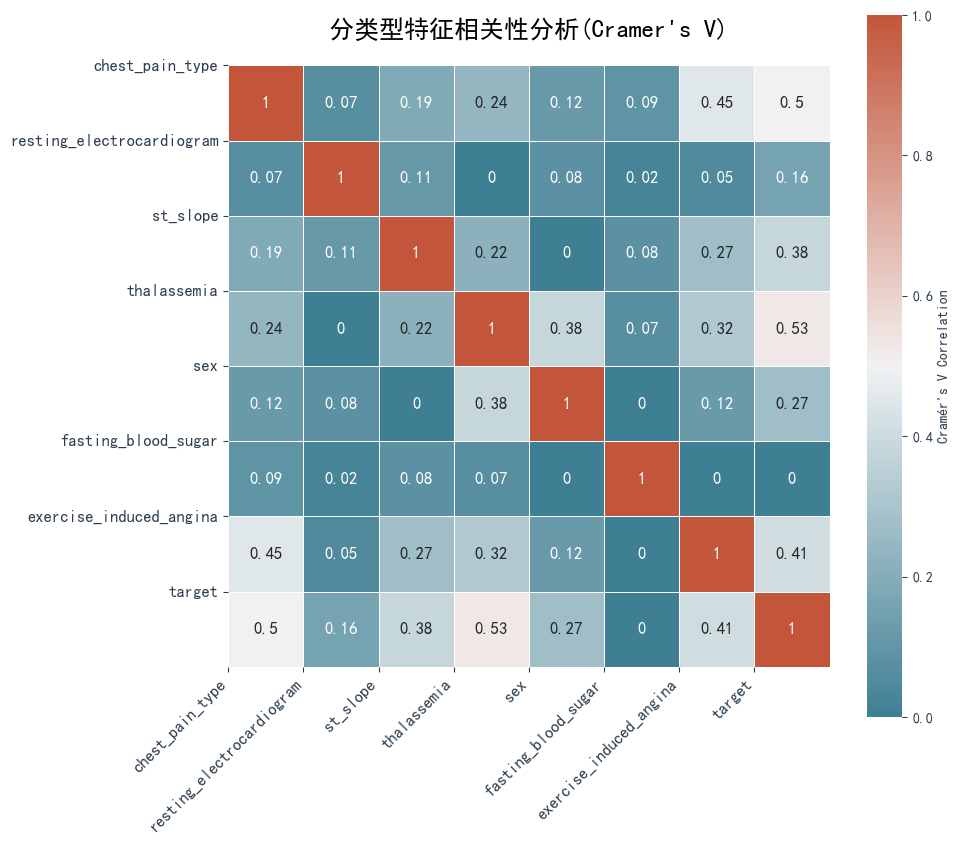

In [723]:
# 定义克莱姆V相关系数计算函数（方法来源：https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9）
def cramers_v(x, y):
    # 生成列联表
    confusion_matrix = pd.crosstab(x, y)
    
    # 计算卡方统计量
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    # 当比较相同变量时直接返回1
    if x.name == y.name:return 1.0
    # 计算phi平方修正值
    phi2 = chi2 / n
    r, k = confusion_matrix.shape  # 获取列联表维度
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))  # 偏差修正
    
    # 计算维度修正值
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    # 返回克莱姆V系数
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# 选择分类特征数据
data_ = data[cat_feats]

# 构建相关系数矩阵
corr_matrix = []
for col1 in data_:
    row = []
    for col2 in data_:
        # 计算每对特征的克莱姆V系数
        cv = cramers_v(data_[col1], data_[col2])
        row.append(round(cv, 2))  # 保留两位小数
    corr_matrix.append(row)

# 转换为DataFrame格式
corr_df = pd.DataFrame(
    corr_matrix,
    columns=data_.columns,
    index=data_.columns
)

# 创建正方形画布
plt.figure(figsize=(10, 10))

# 设置配色（适配0-1范围）
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# 绘制完整热力图
ax = sns.heatmap(
    corr_df,
    cmap=cmap,          # 渐变配色方案
    vmin=0, vmax=1,     # 固定颜色范围
    center=0.5,         # 颜色中心点
    annot=True,          # 显示数值标签
    annot_kws={"size": 12},  # 标签字号
    square=True,         # 单元格保持正方形
    linewidths=0.5,      # 单元格边框宽度
    linecolor='white',   # 边框颜色
    cbar_kws={
        "shrink": 0.8,   # 颜色条缩放比例
        "label": "Cramér's V Correlation"  # 颜色条标签
    }
)

# 设置坐标轴标签
ax.set_xticks(np.arange(len(corr_df.columns)))
ax.set_yticks(np.arange(len(corr_df.columns)))
ax.set_xticklabels(
    corr_df.columns,
    rotation=45,        # X轴标签45度旋转
    ha='right',         # 右对齐
    fontsize=12
)
ax.set_yticklabels(
    corr_df.columns,
    rotation=0,         # Y轴标签不旋转
    fontsize=12
)

# 设置主标题
plt.title(
    "分类型特征相关性分析(Cramer's V)", 
    fontsize=18, 
    pad=20  # 标题下间距
)

# 优化布局显示
plt.tight_layout()

在7个分类型特征中，**胸痛类型（chest_pain_type）、地中海贫血（thalassemia）和运动诱发心绞痛（exercise_induced_angina）** 与目标变量的相关性较强，**相关系数分别为0.5,0.53,0.41。**

### 3.4.4 关于“如何选择合适的相关分析方法”的一点思考

《环境数据分析（第二版）》教材上关于相关性分析主要介绍了简单相关分析中的Pearson 相关分析、Kendall 等级相关分析及 Spearman 等级相关分析，以及偏相关分析。但这里没有采用后三种分析方法，而是采用了点二列相关分析和克莱姆V相关分析。原因及相关的思考主要如下：

**1.不妨先回顾一下书本上关于后面三种相关分析方法的定义：**
- Pearson 相关分析：用于研究两个连续变量相关性的参数方法，衡量双变量线性关系的强度和方向。其对应的相关系数为Pearson 相关系数，又称 Pearson 积矩相关系数。
- Kendall 等级相关分析：用于多列等级变量相关程度的统计分析方法，于 1938 年由英国统计学家莫里斯· 乔治·肯德尔(Maurice George Kendall)提出，属于非参数的等级相关（也称秩相关(rank correlation)）分析。Kendall 相关分析根据两个变量的秩评估变量间的相关关系，常用于连续变量或有序分类变量间的一致性检验。
- Spearman 等级相关分析：主要描述两个等级变量间的关联程度，适用于连续和离散变量。当测量数据是等级数据或等距数据及等比数据，并且总体分布正态性较差，不满足Pearson 相关分析条件时，需采用 Spearman 等级相关分析。

**2.结合上面采用的点二列相关系数（point biserial correlation）、克莱姆V相关系数（cramers'V correlation）做个比较**
| 方法类型       | 适用变量类型           | 上面分析中是否使用 | 原因分析                     |
| :------------- | :--------------------- | :----------- | :--------------------------- |
| Pearson        | 连续 vs 连续           | ✓            | 数值型特征间分析             |
| Spearman       | 连续/等级 vs 连续/等级 | ✗            | 案例未涉及非线性单调关系     |
| Kendall        | 等级数据/小样本        | ✗            | 数据规模较大且无显著秩次问题 |
| Point-biserial | 连续 vs 二分类         | ✓            | 目标变量是二分类的数值型特征 |
| Cramér's V     | 分类型 vs 分类型       | ✓            | 分析分类特征间关联           |

**3.总结一下为啥不用Kendall/Spearman**<br>
- （1）数据特性不匹配：目标变量是二分类名义变量，不是等级变量;分类特征间无序别关系（如性别、胸痛类型）<br>

- （2）方法假设冲突：Spearman要求变量至少是顺序尺度；Kendall在小样本下更有效，而本数据样本量较大（n=303）<br>


**4.“如何选择合适的相关性分析方法”的启发**<br>
**（1）选择准则**
- **第一准则**：变量测量尺度（连续/分类/等级）
- **第二准则**：数据分布特征（正态、线性）
- **第三准则**：分析目标（探索性分析 vs 统计推断）

**（2）适用场景**

| 变量X类型  | 变量Y类型  | 可能适用的方法         |
| :--------- | :--------- | :--------------- |
| 连续       | 连续       | Pearson/Spearman |
| 连续       | 二分类     | Point-biserial   |
| 连续       | 多分类有序 | Kendall     |
| 多分类名义 | 多分类名义 | Cramér's V       |
| 二分类     | 二分类     | Phi系数          |

**（3） 异常情况下的方法选择**

- **存在异常值**：优先使用Spearman
- **小样本数据**：推荐Kendall
- **高维度数据**：考虑距离相关（Distance Correlation）

## 3.5 探索性数据分析(EDA)总结

### 3.5.1 数据概览
**<u>(在写jupyter notebook时把这部分的工作放在了“2.数据预处理”部分)</u>**
| 分析维度         | 描述                           |
|------------------|-------------------------------|
| 原始数据规模      | 303行 × 14列（13个特征 + 目标变量）|
| 清洗后数据规模    | 296行（移除7条异常数据）         |
| 缺失值情况        | 无缺失值                      |
| 数值型特征数量    | 6个                           |
| 分类型特征数量    | 7个                           |
| 目标变量分布      | 54%无心脏病 / 46%患病（说明数据平衡，无需进行过采样/欠采样）          |

### 3.5.2 相关性分析

（1）由皮尔逊相关系数分析知，**预测变量（特征）间不存在多重共线性**。


（2）下表显示了与目标变量相关系数最大的6项特征，根据初步分析，**这些特征可能具有较高的疾病预测效力**
| 总排名 | 特征名称（中文）          | 特征名称（英文）                | 特征类型  | 相关系数 | 相关方向 | 特征说明|
|--------|--------------------------|----------------------------|-----------|----------|----------|----------|
| 1      | 地中海贫血类型           | thalassemia                | 分类型特征    | 0.53     | 正相关   |血液检测异常指标，与心肌供氧能力相关|
| 2      | 主要血管数量             | num_major_vessels          | 数值型特征    | -0.47    | 负相关   |冠状动脉造影可见的主要血管数（0-3个）|
| 3      | 胸痛类型                 | chest_pain_type            | 分类型特征    | 0.50     | 正相关   |反映不同胸痛临床表现与疾病关联|
| 4      | ST段压低值               | st_depression              | 数值型特征    | -0.43    | 负相关   |心电图ST段异常指标|
| 5      | 最大心率                 | max_heart_rate_achieved    | 数值型特征    | 0.43     | 正相关   |负荷试验中记录的心率峰值|
| 6      | 运动诱发心绞痛           | exercise_induced_angina    | 分类型特征    | 0.41     | 正相关   |运动后胸痛症状的临床表征|

**后续将通过机器学习分类模型验证这些特征的重要性。**

# 4 特征工程与特征选择

## 4.1 定义与目标
**特征工程（Feature engineering）** 是指从原始数据中提取特征并将其转化为适合机器学习模型的数据格式。特征工程是数据科学和机器学习的重要环节，将提取特征运用到预测模型上能提高数据的预测精度，有利于提升预测模型。

广义特征工程分为特征使用方案、特征获取、特征处理和特征监控四大部分。**特征处理**是特征工程的核心内容，包括**特征选择、特征构建、特征提取。**

**特征选择**根据各种统计检验的分数及相关性指标，从原始特征中剔除不相关或冗余的特征，选出最有效特征子集以降低数据集维度，降维后的数据集保留原数据集的大部分信息。特征选择可降低计算复杂度，提高模型精确度以及可解释性。

**核心目标：**
- 提升模型预测精度
- 降低计算复杂度
- 增强结果可解释性

## 4.2 保留全部特征的合理性说明

上面的相关性分析实际上属于**特征选择阶段的前置评估**，即通过**过滤式**方法，基于统计指标筛选特征：<br>
-（1）通过计算相关系数矩阵，**识别出与目标变量相关性最高的6个特征**，剔除低相关特征；<br>
-（2）通过分析特征间相关性，**避免多重共线性特征同时入选**。<br>

尽管通过相关性分析识别出**部分特征与目标变量关联较弱**，但后面的机器学习种**仍保留全部13个特征进行建模**，主要基于以下考量：

**1. 多变量协同效应考量**
- **交互作用潜力**：低单变量相关性的特征可能通过特征组合产生预测价值，比如`年龄 × 胆固醇`可能揭示特定年龄段的风险模式
- **非线性关系补偿**：树模型（如随机森林）可自动捕捉非线性关系，比如`胆固醇`水平在极端高值时可能呈现阈值效应

**2. 模型鲁棒性保障**
- **防止信息丢失**：在小样本数据（n=296）中，过早剔除特征易导致信息损失，尤其当n/p<20时（本案n/p≈22.8），特征筛选需谨慎
- **特征间不存在多重共线性**：皮尔逊相关系数矩阵显示特征间最大|r|=0.4（<0.7阈值），不存在多重共线性

**3. 模型自选择能力利用**
- **嵌入式特征选择**：后面部分计划使用的分类模型具备自动特征筛选能力，比如随机森林通过特征重要性评分实现动态筛选
- **SHAP值分析**：可在模型训练后量化各特征的边际贡献，全特征集可支持更全面的特征贡献归因分析

**4. 医学先验知识考量**
- **临床意义保留**：即使统计相关性低，仍保留医学指南推荐指标，如：尽管在上面点二列相关分析中，`胆固醇`与目标变量的相关系数仅为-0.08，几乎不存在相关性，但它在ACC/AHA指南中仍作为风险评估因子，故选择保留完整特征集，以此来验证数据驱动结果与医学共识的一致性

通过这种"先保留后优化"的策略，既可避免前期筛选偏差，又能为后续深度分析提供可靠的对比基线，符合探索性数据分析的最佳实践。

# 5 预测

说明：经过数据清洗后，仅剩下了297个样本数据，这对于标准、严谨的机器学习预测来说实在是非常小的数据量。因此，后面所有模型的预测结果可能都不具备实际临床科学意义😭，就当成一个练习好了。

技术路线分析：这是一个典型的**二分类问题（1：患病，0：健康）**。

## 5.1 Scikit Learn库的传统分类器

“Python机器学习库Scikit-learn 几乎囊括了所有主流机器学习算法，是入门机器学习的主流工具。”（《环境数据分析（第二版）》12.6）

因此，下面将首先使用Scikit-learn中的以下12种模型进行预测：
| 序号 | 中文名称               | 英文名称/类名                 | 模型类型             | 算法类别说明                  |
| :--- | :--------------------- | :---------------------------- | :------------------- | :---------------------------- |
| 1    | 逻辑回归               | LogisticRegression            | 线性模型             | 基于线性决策边界              |
| 2    | K近邻                  | KNeighborsClassifier          | 基于实例的学习       | 距离度量+多数表决             |
| 3    | 支持向量分类器         | SVC                           | 核方法               | 最大间隔超平面                |
| 4    | Nu支持向量分类器       | NuSVC                         | 核方法               | 支持向量比例控制              |
| 5    | 决策树                 | DecisionTreeClassifier        | 树模型               | 规则划分+信息增益             |
| 6    | 随机森林               | RandomForestClassifier        | 集成学习（Bagging）  | 多决策树投票                  |
| 7    | AdaBoost               | AdaBoostClassifier            | 集成学习（Boosting） | 序列增强错分样本权重          |
| 8    | 梯度提升               | GradientBoostingClassifier    | 集成学习（Boosting） | 梯度下降优化残差              |
| 9    | 高斯朴素贝叶斯         | GaussianNB                    | 概率模型             | 基于贝叶斯定理+特征独立性假设 |
| 10   | 线性判别分析           | LinearDiscriminantAnalysis    | 判别分析             | 类间方差最大化投影            |
| 11   | 二次判别分析           | QuadraticDiscriminantAnalysis | 判别分析             | 非线性决策边界                |
| 12   | 多层感知机（神经网络） | MLPClassifier                 | 神经网络             | 前馈人工神经网络              |

### 5.1.1 模型训练

In [741]:
# ================= 库与分类器导入 =================
# 线性模型
from sklearn.linear_model import LogisticRegression  # 逻辑回归（二分类基准模型）
# 基于距离的分类器
from sklearn.neighbors import KNeighborsClassifier   # K近邻（非参数方法）
# 支持向量机系列
from sklearn.svm import SVC, LinearSVC, NuSVC       # SVC（核方法）、LinearSVC（线性优化）、NuSVC（比例控制）
# 决策树模型
from sklearn.tree import DecisionTreeClassifier      # 决策树（可解释性强）
# 集成学习方法
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier  # 随机森林/自适应提升/梯度提升
# 概率模型
from sklearn.naive_bayes import GaussianNB           # 高斯朴素贝叶斯
# 判别分析方法
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis  # 线性/二次判别分析
# 神经网络
from sklearn.neural_network import MLPClassifier     # 多层感知机（前馈神经网络）

# ================= 评估指标与工具 =================
from sklearn.metrics import (confusion_matrix,        # 混淆矩阵
                           ConfusionMatrixDisplay,    # 可视化混淆矩阵
                            classification_report,    # 分类报告（多指标汇总）
                            recall_score,             # 召回率计算
                            accuracy_score,           # 准确率计算
                            roc_curve, auc)           # ROC曲线相关计算
# 数据分割工具
from sklearn.model_selection import train_test_split  # 数据集划分
# 预处理工具
from sklearn.preprocessing import LabelEncoder        # 标签编码器
# 可解释性分析库（shap并不是Python标准库的一部分，也不是Anaconda默认安装的包，所以需要手动安装）
import shap  

In [743]:
def label_encode_cat_features(data, cat_features):
    '''
    对分类特征进行标签编码（Label Encoding）
    
    参数：
        data: pd.DataFrame - 包含原始特征的数据框
        cat_features: list - 需要编码的分类特征列表
    
    返回：
        data: pd.DataFrame - 编码后的数据框（原地修改）
    
    实现逻辑：
        1. 创建数据副本防止污染原始数据
        2. 遍历每个分类特征：
           - 初始化标签编码器
           - 对特征值进行编码（如['a','b','c'] → [0,1,2]）
        3. 返回编码后的数据副本
    '''
    label_encoder = LabelEncoder()
    data_encoded = data.copy()  # 创建副本避免修改原始数据
    
    # 遍历每个分类特征进行编码
    for col in cat_features:
        # 自动学习类别映射并转换数据
        data_encoded[col] = label_encoder.fit_transform(data[col])
    
    data = data_encoded  # 更新原始数据引用
    return data

In [745]:
# ================= 数据预处理 =================
cat_features = cat_feats  # 从外部变量获取分类特征列表
data = label_encode_cat_features(data, cat_features)  # 执行分类特征编码
# 设置随机种子（保证实验可重复性）
seed = 0  
# 验证集比例
test_size = 0.25  
# 特征/标签分离
features = data.columns[:-1]  # 最后一列为目标变量
X = data[features]  # 特征矩阵
y = data['target']  # 目标向量
# 分层分割数据集（保持类别分布）
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=test_size, 
    random_state=seed,
    stratify=y  # 关键参数：保持分割后数据集中类别比例
)
# ================= 分类器初始化 =================
# 分类器名称列表（显示用）
names = [
    'Logistic Regression',   # 逻辑回归
    'Nearest Neighbors',     # K近邻（K=2）
    'Support Vectors',       # 支持向量机（默认RBF核）
    'Nu SVC',                # Nu支持向量机
    'Decision Tree',         # 决策树
    'Random Forest',         # 随机森林
    'AdaBoost',              # 自适应提升
    'Gradient Boosting',     # 梯度提升树
    'Naive Bayes',           # 高斯朴素贝叶斯
    'Linear DA',             # 线性判别分析
    'Quadratic DA',          # 二次判别分析
    "Neural Net"             # 多层感知机（神经网络）
]
# 分类器实例列表（与名称顺序严格对应）
classifiers = [
    # 逻辑回归（小数据集适用liblinear求解器）
    LogisticRegression(solver="liblinear", random_state=seed),
    # K近邻（设置近邻数K=2）
    KNeighborsClassifier(2),
    # 支持向量机（启用概率预测）
    SVC(probability=True, random_state=seed),
    # Nu支持向量机（控制支持向量比例）
    NuSVC(probability=True, random_state=seed),
    # 决策树（固定随机种子）
    DecisionTreeClassifier(random_state=seed),
    # 随机森林（默认100棵树）
    RandomForestClassifier(random_state=seed),
    # AdaBoost（默认50个弱分类器）
    AdaBoostClassifier(random_state=seed),
    # 梯度提升树（学习率=0.1）
    GradientBoostingClassifier(random_state=seed),
    # 高斯朴素贝叶斯（无参数需设定）
    GaussianNB(),
    # 线性判别分析（维度压缩方法）
    LinearDiscriminantAnalysis(),
    # 二次判别分析（允许非线性边界）
    QuadraticDiscriminantAnalysis(),
    # 多层感知机（默认1个隐藏层：100个神经元）
    MLPClassifier(random_state=seed),
]

### 5.1.2 性能比较

#### 5.1.2.1 混淆矩阵（Confusion matrix）

混淆矩阵(confusion matrix)：是一种用于比较分类结果和实际测值的可视化手段。每一列代表预测结果，预测为正 P(Positive)，预测为负 N(Negative)。每一行代表数据的真实类别，属于真 T(True)或假 F(False)。

- 真阳性(true positive, TP)：样本真实类别是正例，模型预测结果为正例。
- 真阴性(true negative, TN)：样本真实类别是负例，模型预测结果为负例。
- 假阳性(false positive, FP)：样本真实类别是负例，模型预测结果为正例。
- 假阴性(false negative, FN)：样本真实类别是正例，模型预测结果为负例。

| 实际类别 \ 预测类别 | Positive | Negative |  
|---------------------|----------|----------|  
| **Positive**        | TP       | FN       |  
| **Negative**        | FP       | TN       |  

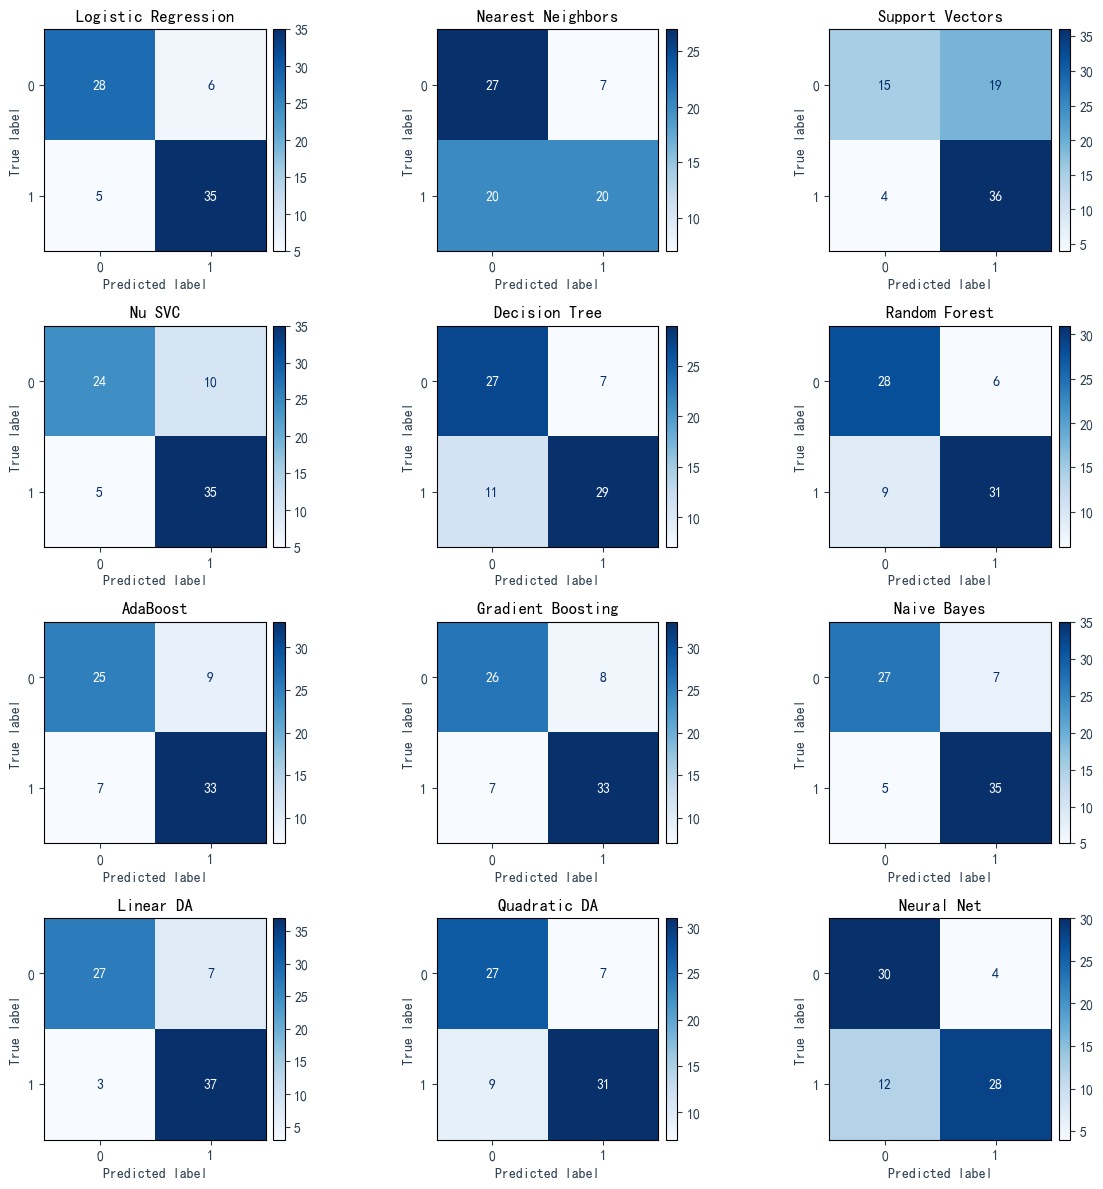

In [750]:
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.metrics import ConfusionMatrixDisplay  

def plot_conf_matrix(names, classifiers, nrows, ncols, fig_a, fig_b):  
    '''  
    绘制混淆矩阵子图  
    '''  
    # 创建子图画布  
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_a, fig_b))  
    
    # 图例的最大值和最小值（根据需要可以调整）  
    vmin = 0  
    vmax = 1  

    # 在每个子图绘制对应分类器的混淆矩阵  
    for i, (clf, ax) in enumerate(zip(classifiers, axes.flatten())):  
        clf.fit(X_train, y_train)  
        y_pred = clf.predict(X_val)  
        
        # 使用新 API 绘制混淆矩阵  
        cax = ConfusionMatrixDisplay.from_predictions(  
            y_val, y_pred,  
            ax=ax,  
            cmap='Blues',  
            colorbar=False  # 初始不显示 colorbar  
        )  
        ax.title.set_text(names[i])  
        
        # 自定义 colorbar  
        cbar = plt.colorbar(cax.im_, ax=ax, pad=0.02)  

    plt.tight_layout()  # 自动调整子图间距  
    plt.show()  

# 调用函数  
plot_conf_matrix(names, classifiers, nrows=4, ncols=3, fig_a=12, fig_b=12)  

#### 5.1.2.2 ROC曲线

受试者工作特征曲线（ROC）通过图形展示二分类算法性能，横轴为假阳性率（FPR），纵轴为真阳性率（TPR）：  
$$
\text{TPR} = \frac{TP}{TP + FN}, \quad \text{FPR} = \frac{FP}{FP + TN}
$$

曲线下面积（AUC）量化模型整体区分能力：  
- 完美分类器：AUC = 1.0  
- 随机猜测基线：AUC = 0.5

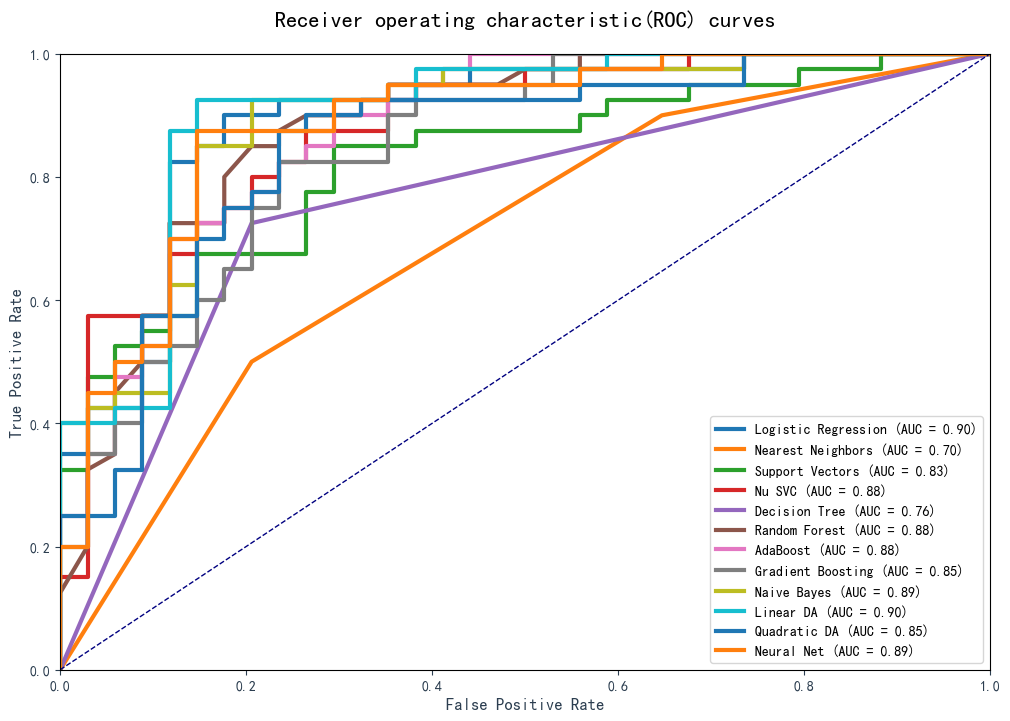

In [754]:
def roc_auc_curve(names, classifiers):
    '''
    绘制多分类器的ROC曲线对比图
    可视化内容：
        - 每个分类器的ROC曲线（含AUC值）
        - 对角线虚线表示随机猜测基准线
        - 图例显示各分类器名称及AUC值
    '''
    plt.figure(figsize=(12, 8))  # 设置画布尺寸
    # 遍历每个分类器绘制ROC曲线
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        # 获取预测概率
        pred_proba = clf.predict_proba(X_val)[:, 1]
        # 计算ROC曲线参数
        fpr, tpr, _ = roc_curve(y_val, pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # 绘制曲线
        plt.plot(fpr, tpr, lw=3, 
                label=f'{name} (AUC = {roc_auc:.2f})')
    # 绘制随机猜测基准线
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    # 坐标轴设置
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver operating characteristic(ROC) curves', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)

roc_auc_curve(names, classifiers)

#### 5.1.2.3 性能指标汇总表（Performance metrics summary table）

**核心指标**

1. **准确率（Accuracy）**  
   模型正确识别的样本比例：  
   $$
   \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
   $$

2. **召回率/敏感度（Recall/Sensitivity）**  
   实际阳性样本中被正确识别的比例：  
   $$
   \text{Recall} = \frac{TP}{TP + FN}
   $$

3. **精确率（Precision）**  
   预测为阳性的样本中真实阳性的比例：  
   $$
   \text{Precision} = \frac{TP}{TP + FP}
   $$

4. **F1分数（F1-Score）**  
   精确率与召回率的调和平均值：  
   $$
   \text{F1} = \frac{2 \times \text{Recall} \times \text{Precision}}{\text{Recall} + \text{Precision}}
   $$


In [758]:
def score_summary(names, classifiers):
    '''
    生成分类模型评估指标汇总表
    返回：
        data_table: pd.DataFrame - 包含以下指标的表格：
            - Accuracy（准确率）
            - ROC_AUC（ROC曲线下面积）
            - Recall（召回率）
            - Precision（精确率）
            - F1 Score（F1值）
    '''
    cols=["Classifier", "Accuracy", "ROC_AUC", "Recall", "Precision", "F1"]
    data_table = pd.DataFrame(columns=cols)
    
    # 遍历每个分类器进行训练评估
    for name, clf in zip(names, classifiers):        
        clf.fit(X_train, y_train)  # 模型训练
        
        # 预测结果
        pred = clf.predict(X_val)
        # 计算准确率（整体预测正确率）
        accuracy = accuracy_score(y_val, pred)

        # 获取预测概率（用于ROC计算）
        pred_proba = clf.predict_proba(X_val)[:, 1]
        # 计算ROC曲线参数
        fpr, tpr, thresholds = roc_curve(y_val, pred_proba)        
        roc_auc = auc(fpr, tpr)  # 曲线下面积
        
        # 构建混淆矩阵
        cm = confusion_matrix(y_val, pred)
        # 计算召回率（敏感度）
        recall = cm[1,1]/(cm[1,1] + cm[1,0])  # TP/(TP+FN)
        # 计算精确率（阳性预测值）
        precision = cm[1,1]/(cm[1,1] + cm[0,1])  # TP/(TP+FP)
        # 计算F1分数（精确率与召回率的调和平均）
        f1 = 2*recall*precision/(recall + precision)

        # 存储结果
        df = pd.DataFrame([[name, accuracy*100, roc_auc, recall, precision, f1]], columns=cols)
        data_table = pd.concat([data_table, df], ignore_index=True)   

    return np.round(data_table.reset_index(drop=True), 2)

In [760]:
(
    score_summary(names, classifiers)
    .sort_values(by='Accuracy', ascending=False)
    .style
    # 核心样式增强
    .background_gradient(
        subset=['Accuracy'], 
        cmap='RdYlGn',        
        vmin=70,           
        vmax=100,           
        gmap=np.linspace(0, 1, len(names))
    )
    # 文字可见性保障
    .set_properties(
        subset=['Accuracy'],
        **{
            'color': 'black',              # 强制黑色字体
            'font-weight': '600',          # 加粗显示
            'text-shadow': '0 0 1px white' # 白色文字阴影（防融色）
        }
    )
    .bar(
        subset=["ROC_AUC"],
        color='#6495ED',
        align='mid',          # 条形居中显示
        height=50,            # 降低条形高度
        width=95              # 增加条形宽度
    )
    .bar(subset=["Recall"], 
        color='#ff355d',
        height=40,
        width=90)
    .bar(subset=["Precision"], 
        color='lightseagreen',
        height=40,
        width=90)
    .bar(subset=["F1"], 
        color='gold',
        height=40,
        width=90)
    # 文字可见性增强
    .set_properties(**{
        'color': 'black',                  # 强制黑色字体
        'font-family': 'Arial',            # 清晰字体
        'font-size': '12px',               # 适当字号
        'font-weight': '500'               # 中等字重
    })
    .set_table_styles([{
        'selector': 'td', 
        'props': [
            ('background-color', 'white'), # 单元格基础背景
            ('box-shadow', 'inset 0 0 2px #f0f0f0')  # 内阴影增强层次
        ]
    }], overwrite=False)
)

,Classifier,Accuracy,ROC_AUC,Recall,Precision,F1
9,Linear DA,86.490000,0.900000,0.920000,0.840000,0.880000
0,Logistic Regression,85.140000,0.900000,0.880000,0.850000,0.860000
8,Naive Bayes,83.780000,0.890000,0.880000,0.830000,0.850000
3,Nu SVC,79.730000,0.880000,0.880000,0.780000,0.820000
5,Random Forest,79.730000,0.880000,0.780000,0.840000,0.810000
7,Gradient Boosting,79.730000,0.850000,0.820000,0.800000,0.810000
6,AdaBoost,78.380000,0.880000,0.820000,0.790000,0.800000
10,Quadratic DA,78.380000,0.850000,0.780000,0.820000,0.790000
11,Neural Net,78.380000,0.890000,0.700000,0.880000,0.780000
4,Decision Tree,75.680000,0.760000,0.720000,0.810000,0.760000


评估分类算法性能时存在多种指标，选择恰当的性能指标需根据具体问题具体分析。

由于本数据集处理的是**医疗案例（判断是否患有心脏病）**，确定需重点考虑的性能指标如下：
1. **召回率（Recall）优先**：避免假阴性（漏诊患病患者）
2. **精确率（Precision）控制**：防止假阳性（健康人被误诊）
3. **F1-score平衡性**：调和召回率与精确率的黄金指标

由此可以得出最佳的3种模型：
| 模型             | Recall | Precision | F1   | ROC AUC | 可解释性 | 训练速度 |
| :--------------- | :----- | :-------- | :--- | :------ | :------- | :------- |
| **Linear DA**    | 0.92   | 0.84      | 0.88 | 0.90    | ★★★★☆    | 极快     |
| **Logistic Reg** | 0.88   | 0.85      | 0.86 | 0.90    | ★★★★★    | 极快     |
| **Naive Bayes**  | 0.88   | 0.83      | 0.85 | 0.89    | ★★★★☆    | 最快     |

综上，**线性判别分析Linear Discriminant Analysis (LDA)** 召回率和F1分数均为最优，漏诊风险最低，综合平衡性最佳，同时还是AUC最佳的模型之一，说明具有优秀的整体判别能力。所以下面将选择该模型进行**超参数调优**。

### 5.1.3 超参数调优（Parameter Tuning）——线性判别分析（LDA）模型

超参数是用来控制算法性能的参数，不同超参数值对模型性能影响不同。超参数调优是为机器学习算法选择一组最优超参数的过程，在给定参数空间内进行搜索，比较不同参数下模型性能，确定最佳超参数集。

在调优过程中不能使用测试集进行评估，用测试集调参可能导致模型过拟合，降低泛化能力。一般采用验证集进行参数优化，测试集进行泛化误差评估。常用调参技术有手动调参、网格搜索、随机搜索、贝叶斯优化等。

当对模型超参数缺乏了解时，可先采用随机搜索缩小参数范围，然后进一步进行网格搜索。

下面采用**随机搜索（RandomizedSearch）对线性判别分析（LDA）模型进行调优**

In [765]:
# ================= 库与分类器导入 =================  
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  
from sklearn.model_selection import RandomizedSearchCV  
from scipy.stats import uniform  
from sklearn.metrics import classification_report, confusion_matrix  
import matplotlib.pyplot as plt  
import seaborn as sns  
# 设置随机种子（保证实验可重复性）  
seed = 0  
# 初始化线性判别分析（LDA）分类器  
lda = LinearDiscriminantAnalysis()  
# 定义参数空间  
space = dict(solver=['svd', 'lsqr', 'eigen'],   
             priors=[None, [0.5, 0.5]],   
             shrinkage=[None, 'auto', True])  
# 进行随机搜索  
search = RandomizedSearchCV(lda,   
                             space,   
                             random_state=seed,  
                             cv=5,   
                             scoring='f1')  

# 拟合模型  
rand_search = search.fit(X_train, y_train)  

              precision    recall  f1-score   support

           0       0.90      0.82      0.86        34
           1       0.86      0.93      0.89        40

    accuracy                           0.88        74
   macro avg       0.88      0.87      0.88        74
weighted avg       0.88      0.88      0.88        74



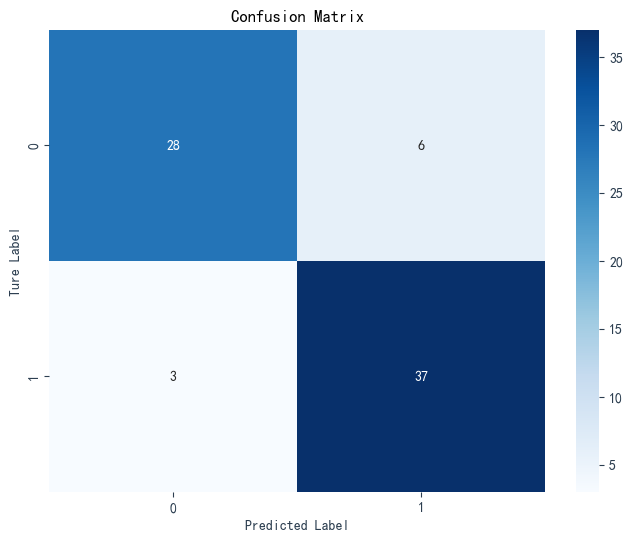

In [767]:
# 使用最佳超参数初始化线性判别分析模型  
params = rand_search.best_params_  
lda = LinearDiscriminantAnalysis(**params)  

# 训练模型  
lda.fit(X_train, y_train)  

# 打印分类报告  
y_pred = lda.predict(X_val)  
print(classification_report(y_val, y_pred))  

# 自定义绘制混淆矩阵  
cm = confusion_matrix(y_val, y_pred)  
plt.figure(figsize=(8, 6))  
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])  
plt.ylabel('Ture Label')  
plt.xlabel('Predicted Label')  
plt.title('Confusion Matrix')  
plt.show()  

**将调优后的模型与原模型进行性能指标比较**

In [770]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score  

# 颜色和格式定义
RESET = "\033[0m"
BOLD = "\033[1m"
GREEN = "\033[92m"
RED = "\033[91m"
BLUE = "\033[94m"
YELLOW = "\033[93m"

# 原始模型的性能指标  
original_metrics = {  
    "Accuracy": 86.49,  
    "ROC_AUC": 0.90,  
    "Recall": 0.92,  
    "Precision": 0.84,  
    "F1": 0.88  
}  

# 评估参数调优后的模型
y_pred_tuned = lda.predict(X_val)  # 对验证集进行预测  

# 计算调优后的模型性能指标  
tuned_metrics = {  
    "Accuracy": accuracy_score(y_val, y_pred_tuned) * 100,  
    "ROC_AUC": roc_auc_score(y_val, lda.predict_proba(X_val)[:, 1]),  
    "Recall": recall_score(y_val, y_pred_tuned),  
    "Precision": precision_score(y_val, y_pred_tuned),  
    "F1": f1_score(y_val, y_pred_tuned)  
}  

# 打印带颜色和边框的对比表格
print(f"\n{BLUE}╔═════════════════╦══════════════════════╦══════════════════════╗{RESET}")
print(f"{BLUE}║{RESET}{YELLOW}{BOLD} {'Metric':<15} {RESET}{BLUE}║{RESET}{YELLOW}{BOLD} {'Original Model':<20} {RESET}{BLUE}║{RESET}{YELLOW}{BOLD} {'Tuned Model':<20} {RESET}{BLUE}║{RESET}")
print(f"{BLUE}╠═════════════════╬══════════════════════╬══════════════════════╣{RESET}")

for metric in original_metrics.keys():
    orig_val = original_metrics[metric]
    tuned_val = tuned_metrics[metric]
    
    # 数值格式化
    if metric == "Accuracy":
        orig_str = f"{orig_val:.2f}%"
        tuned_str = f"{tuned_val:.2f}%"
    else:
        orig_str = f"{orig_val:.4f}"
        tuned_str = f"{tuned_val:.4f}"
    
    # 颜色判断（指标越高越好）
    if tuned_val > orig_val:
        color = GREEN
    elif tuned_val < orig_val:
        color = RED
    else:
        color = RESET
    
    print(f"{BLUE}║{RESET} {metric:<15} {BLUE}║{RESET} {orig_str:<20} {BLUE}║{RESET} {color}{tuned_str:<20}{RESET} {BLUE}║{RESET}")

print(f"{BLUE}╚═════════════════╩══════════════════════╩══════════════════════╝{RESET}\n")


╔═════════════════╦══════════════════════╦══════════════════════╗
║ Metric          ║ Original Model       ║ Tuned Model          ║
╠═════════════════╬══════════════════════╬══════════════════════╣
║ Accuracy        ║ 86.49%               ║ 87.84%               ║
║ ROC_AUC         ║ 0.9000               ║ 0.9059               ║
║ Recall          ║ 0.9200               ║ 0.9250               ║
║ Precision       ║ 0.8400               ║ 0.8605               ║
║ F1              ║ 0.8800               ║ 0.8916               ║
╚═════════════════╩══════════════════════╩══════════════════════╝



由上表：
（1）调优后的模型在**各个性能指标上均有不同程度的提升**，尤其是在精准率和召回率的平衡方面。
（2）尽管原始模型表现已经不俗，但经过参数调优的模型进一步提升了性能，表明超参数调优是有益的，尤其是在复杂的模型中。
（3）调优后的模型在实际应用中可能能够更好地满足需求，尤其是在需要兼顾假阳性和假阴性时。

需要注意的是，**由于本数据集规模较小，导致这些提升在各项指标上都很小**，但在实际应用中，尤其是当数据量较大或事件发生率较低时，这些提升可能会产生显著的影响。

## 5.2 基于梯度提升优化的算法（Catboost, Lgbm, Xgboost）

在上面的部分（5.1），我们已经应用了来自 scikit-learn 库的12种分类器。下面将尝试一些更高级的机器学习算法，例如 **CatBoost、XGBoost 和 LightGBM**，他们都是**基于梯度提升技术优化的机器学习算法**。

### 5.2.1 模型训练

In [776]:
# 导入三大主流梯度提升树模型库
from catboost import CatBoostClassifier  
from xgboost import XGBClassifier  
from lightgbm import LGBMClassifier  

# 定义模型名称列表（用于后续可视化标识）
names_boost = [  
    'Catboost',   # CatBoost模型标签
    'XGBoost',    # XGBoost模型标签
    'LightGBM'    # LightGBM模型标签
]  

# 初始化分类器对象列表（与names_boost顺序一致）
classifiers = [  
    # CatBoost分类器（静默模式）
    CatBoostClassifier(random_state=seed, verbose=0),  
    # XGBoost分类器（指定二分类目标函数）
    XGBClassifier(objective='binary:logistic', random_state=seed),  
    # LightGBM分类器
    LGBMClassifier(random_state=seed)  
]  

### 5.2.2 模型比较

In [779]:
# 模型评估与可视化流程
score_summary(names_boost, classifiers).sort_values(by='Accuracy' , ascending = False)\
.style.background_gradient(cmap='coolwarm')\
.bar(subset=["ROC_AUC",], color='#6495ED')\
.bar(subset=["Recall"], color='#ff355d')\
.bar(subset=["Precision"], color='lightseagreen')\
.bar(subset=["F1"], color='gold')

,Classifier,Accuracy,ROC_AUC,Recall,Precision,F1
0,Catboost,85.140000,0.890000,0.850000,0.870000,0.860000
1,XGBoost,82.430000,0.880000,0.850000,0.830000,0.840000
2,LightGBM,79.730000,0.890000,0.820000,0.800000,0.810000


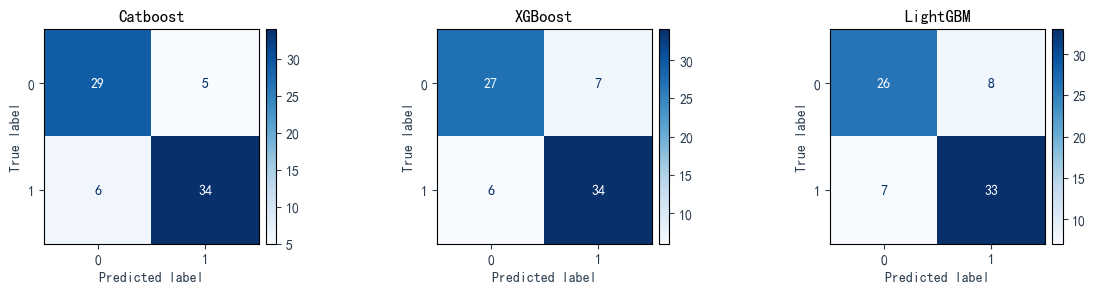

In [780]:
# 绘制混淆矩阵可视化图
plot_conf_matrix(names=names_boost, classifiers=classifiers, nrows=1, ncols=3, fig_a=12, fig_b=3);

这里我们可以看到Catboost模型的**各项指标均为最优**，故下面**对Catboost模型进行超参数调优**。

### 5.2.3 超参数调优（Parameter Tuning）——Catboost模型

In [806]:
from catboost import CatBoostClassifier  
from sklearn.model_selection import RandomizedSearchCV  
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay  
import matplotlib.pyplot as plt  

# 设置超参数的范围  
rs_params = {  
    'depth': [4, 6, 8, 10],         # 树的深度  
    'learning_rate': [0.01, 0.1, 0.2],  # 学习率  
    'iterations': [200, 400, 600],  # 迭代次数  
    'l2_leaf_reg': [1, 3, 5, 7]     # L2 正则化系数  
}  

# 创建 CatBoostClassifier 实例  
catboost_model = CatBoostClassifier(random_state=seed, verbose=0)  

# 使用 RandomizedSearchCV 进行超参数调优  
rs_cv = RandomizedSearchCV(estimator=catboost_model,   
                           param_distributions=rs_params,   
                           n_iter=10,          # 随机搜索的次数  
                           scoring='accuracy',   
                           cv=5)  

# 拟合模型  
rs_cv.fit(X_train, y_train)  
params = rs_cv.best_params_  
params

{'learning_rate': 0.01, 'l2_leaf_reg': 5, 'iterations': 200, 'depth': 4}

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        34
           1       0.88      0.88      0.88        40

    accuracy                           0.86        74
   macro avg       0.86      0.86      0.86        74
weighted avg       0.86      0.86      0.86        74



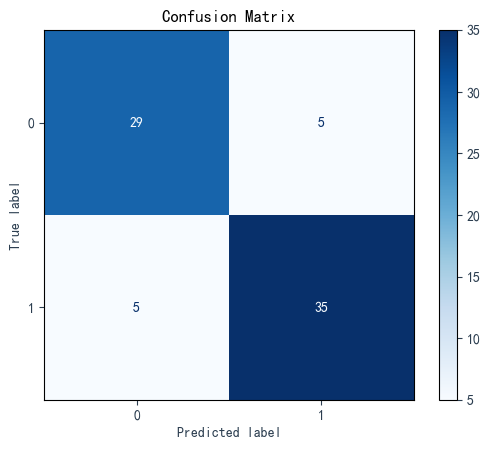

In [808]:
# 使用最佳参数初始化模型  
catboost_tuned = CatBoostClassifier(**params)  

# 拟合调优后的模型  
catboost_tuned.fit(X_train, y_train,  
                    eval_set=(X_val, y_val),  
                    verbose=False)  

# 打印分类报告  
y_pred = catboost_tuned.predict(X_val)  
print(classification_report(y_val, y_pred))  

# 绘制混淆矩阵  
cm = confusion_matrix(y_val, y_pred)  
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(cmap=plt.cm.Blues)  
plt.title("Confusion Matrix")  
plt.show()  

In [894]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score  

# 颜色和格式定义  
RESET = "\033[0m"  
BOLD = "\033[1m"  
GREEN = "\033[92m"  
RED = "\033[91m"  
BLUE = "\033[94m"  
YELLOW = "\033[93m"  

# 原始模型的性能指标  
original_metrics = {  
    "Accuracy": 85.14,  #原始指标  
    "ROC_AUC": 0.89,  
    "Recall": 0.85,  
    "Precision": 0.87,  
    "F1": 0.86  
}  

# 评估参数调优后的模型  
y_pred_tuned = catboost_tuned.predict(X_val)  # 对验证集进行预测  

# 计算调优后的模型性能指标  
tuned_metrics = {  
    "Accuracy": accuracy_score(y_val, y_pred_tuned) * 100,  
    "ROC_AUC": roc_auc_score(y_val, catboost_tuned.predict_proba(X_val)[:, 1]),  
    "Recall": recall_score(y_val, y_pred_tuned),  
    "Precision": precision_score(y_val, y_pred_tuned),  
    "F1": f1_score(y_val, y_pred_tuned)  
}  

# 打印带颜色和边框的对比表格  
print(f"\n{BLUE}╔═════════════════╦══════════════════════╦══════════════════════╗{RESET}")  
print(f"{BLUE}║{RESET}{YELLOW}{BOLD} {'Metric':<15} {RESET}{BLUE}║{RESET}{YELLOW}{BOLD} {'Original Model':<20} {RESET}{BLUE}║{RESET}{YELLOW}{BOLD} {'Tuned Model':<20} {RESET}{BLUE}║{RESET}")  
print(f"{BLUE}╠═════════════════╬══════════════════════╬══════════════════════╣{RESET}")  

for metric in original_metrics.keys():  
    orig_val = original_metrics[metric]  
    tuned_val = tuned_metrics[metric]  
    
    # 数值格式化  
    if metric == "Accuracy":  
        orig_str = f"{orig_val:.2f}%"  
        tuned_str = f"{tuned_val:.2f}%"  
    else:  
        orig_str = f"{orig_val:.4f}"  
        tuned_str = f"{tuned_val:.4f}"  
    
    # 颜色判断（指标越高越好）  
    if tuned_val > orig_val:  
        color = GREEN  
    elif tuned_val < orig_val:  
        color = RED  
    else:  
        color = RESET  
    
    print(f"{BLUE}║{RESET} {metric:<15} {BLUE}║{RESET} {orig_str:<20} {BLUE}║{RESET} {color}{tuned_str:<20}{RESET} {BLUE}║{RESET}")  

print(f"{BLUE}╚═════════════════╩══════════════════════╩══════════════════════╝{RESET}\n")  


╔═════════════════╦══════════════════════╦══════════════════════╗
║ Metric          ║ Original Model       ║ Tuned Model          ║
╠═════════════════╬══════════════════════╬══════════════════════╣
║ Accuracy        ║ 85.14%               ║ 86.49%               ║
║ ROC_AUC         ║ 0.8900               ║ 0.8912               ║
║ Recall          ║ 0.8500               ║ 0.8750               ║
║ Precision       ║ 0.8700               ║ 0.8750               ║
║ F1              ║ 0.8600               ║ 0.8750               ║
╚═════════════════╩══════════════════════╩══════════════════════╝



上表表明，经过超参数调优后，假阴性（漏检）减少，模型整体区分能力保持稳定，模型在减少假阳性（误报）和假阴性（漏检）间取得更好平衡。

# 6 模型解释(Model Explainablity)

机器学习项目面临的挑战之一是**解释模型的预测**。一个模型可能会认为某些特征对其预测更重要，而另一个模型可能会将其他特征视为更重要。

**SHAP（SHapley Additive ExPlanations，沙普利加性解释）** 是一种用于解释机器学习模型输出的方法。它通过博弈论中的经典沙普利值（Shapley values）及其相关扩展，将最优信用分配与局部解释相结合。SHAP具有丰富的功能，可帮助我们可视化/解释模型的输出结果。**下方使用shap.summary_plot()函数来识别各特征对上面最优的两种模型（Catboost，LDA）预测输出的影响程度。**

## 6.1 SHAP分析（Catboost）

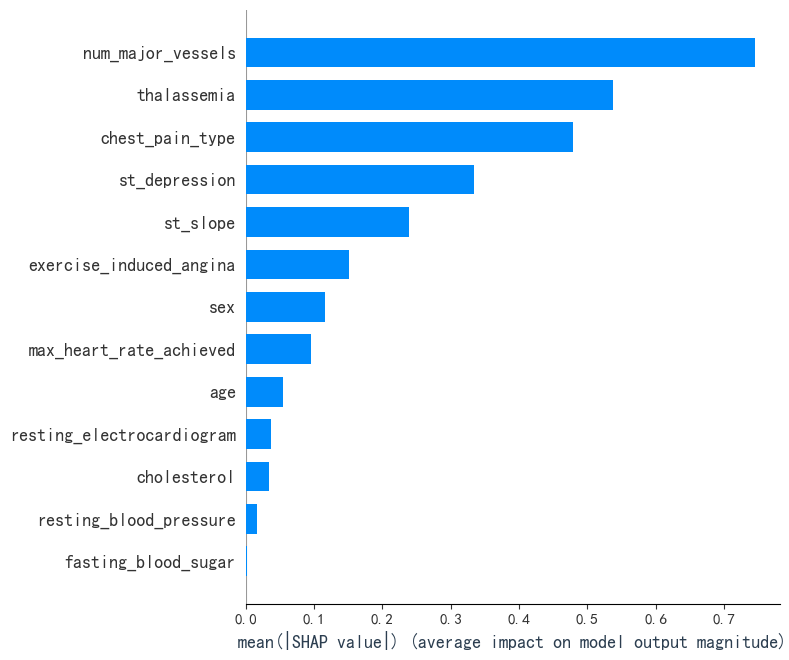

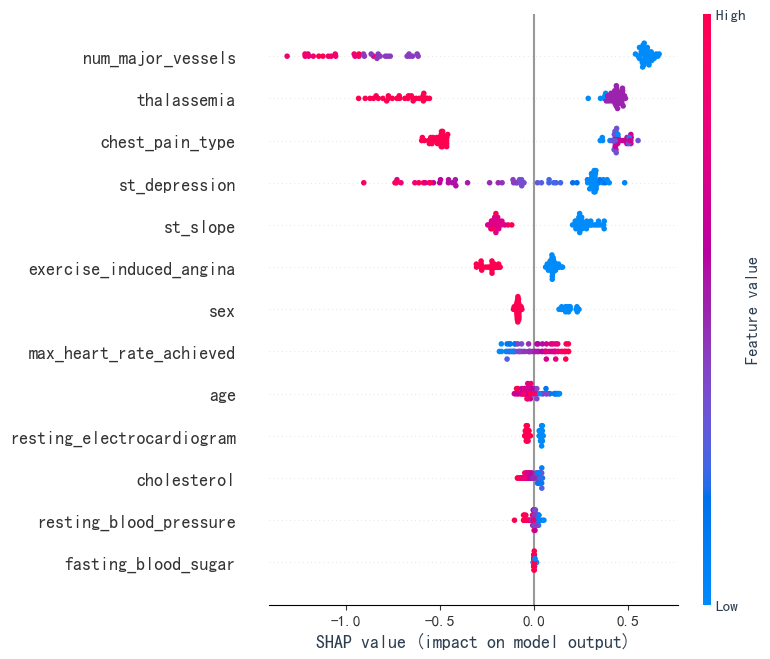

In [889]:
import shap
import matplotlib.pyplot as plt

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 初始化SHAP
shap.initjs()

# 创建CatBoost专用解释器
explainer = shap.TreeExplainer(catboost_tuned)  # 使用调优后的模型

# 动态调整抽样量（不超过验证集实际样本数）
sample_size = min(100, len(X_val))  # 自动取100和实际样本数的较小值
sample_idx = X_val.sample(sample_size, replace=(sample_size > len(X_val))).index

# 计算验证集SHAP值
shap_values = explainer.shap_values(X_val.loc[sample_idx])

# 绘制全局特征重要性（条形图）
shap.summary_plot(shap_values, 
                 X_val.loc[sample_idx], 
                 feature_names=X_val.columns.tolist(),
                 plot_type="bar",
                 show=False)
plt.tight_layout()
plt.show()

# 绘制特征效应分布图（点图）
shap.summary_plot(shap_values,
                 X_val.loc[sample_idx],
                 feature_names=X_val.columns.tolist(),
                 show=False)
plt.tight_layout()
plt.show()

## 6.2 SHAP分析（LDA）

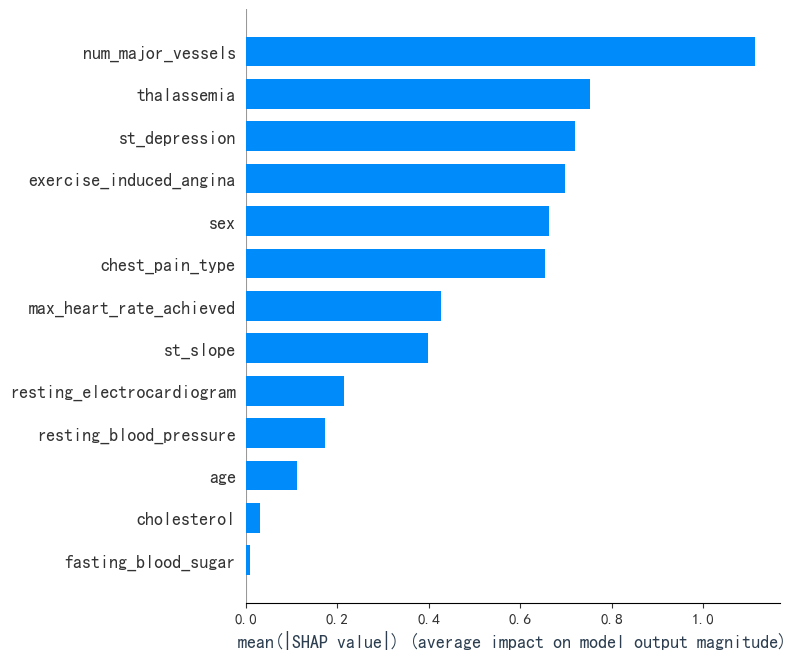

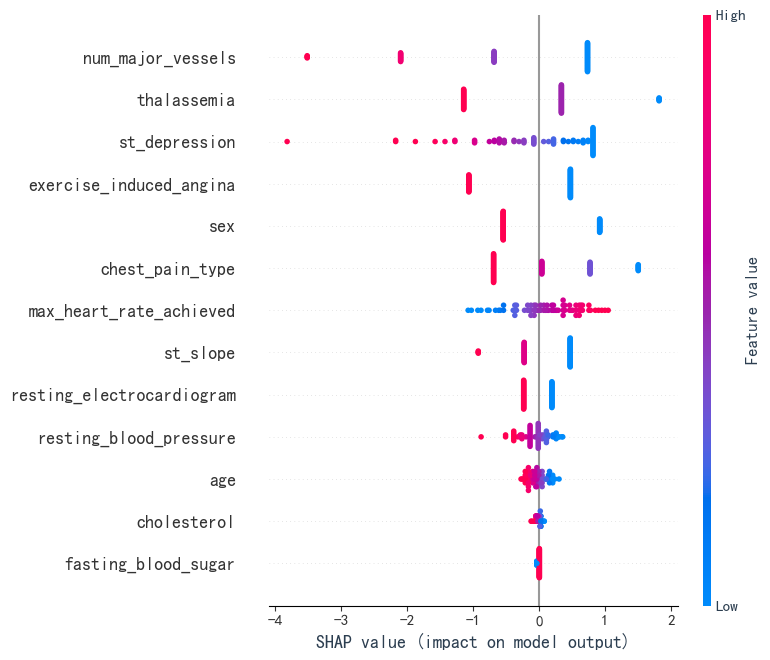

In [891]:
import shap  
import matplotlib
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 初始化SHAP  
shap.initjs()  

# 使用SHAP LinearExplainer进行解释  
explainer = shap.LinearExplainer(lda, X_train)  

# 计算验证集的SHAP值  
shap_values = explainer.shap_values(X_val)  

# 绘制SHAP值的摘要图（条形图）  
shap.summary_plot(shap_values, X_val,   
                  feature_names=X_val.columns.tolist(),   
                  plot_type="bar")  

# 对单个类别绘制详细的SHAP值图  
shap.summary_plot(shap_values, X_val)  

## 6.3 SHAP分析总结

回顾一下前期做的**特征-目标变量相关性分析**结果（如下表所示，**见3.5.2**）

| 总排名 | 特征名称（中文）          | 特征名称（英文）                | 特征类型  | 相关系数 | 相关方向 | 特征说明|
|--------|--------------------------|----------------------------|-----------|----------|----------|----------|
| 1      | 地中海贫血类型           | thalassemia                | 分类型特征    | 0.53     | 正相关   |血液检测异常指标，与心肌供氧能力相关|
| 2      | 主要血管数量             | num_major_vessels          | 数值型特征    | -0.47    | 负相关   |冠状动脉造影可见的主要血管数（0-3个）|
| 3      | 胸痛类型                 | chest_pain_type            | 分类型特征    | 0.50     | 正相关   |反映不同胸痛临床表现与疾病关联|
| 4      | ST段压低值               | st_depression              | 数值型特征    | -0.43    | 负相关   |心电图ST段异常指标|
| 5      | 最大心率                 | max_heart_rate_achieved    | 数值型特征    | 0.43     | 正相关   |负荷试验中记录的心率峰值|
| 6      | 运动诱发心绞痛           | exercise_induced_angina    | 分类型特征    | 0.41     | 正相关   |运动后胸痛症状的临床表征|


再结合上面的shap.summary_plot()对最优模型CatBoost与LDA进行特征影响力评估的结果，发现以下关键结论。

### 6.3.1 全局一致性验证
   - **num_major_vessels**（主要血管数量）在两种模型的SHAP分析中均居首位，与相关系数排名第2（|-0.47|）高度吻合，验证了该特征在心血管疾病预测中的核心地位
   - **thalassemia**（地中海贫血类型）在SHAP分析中均列第2位，与其相关系数首位（0.53）匹配，表明该血液指标对模型预测具有稳定贡献

### 6.3.2 模型差异

| 排名 | CatBoost特征              | LDA特征                        | 相关系数排名 |
| :--- | :------------------------ | :----------------------------- | :----------- |
| 1    | num_major_vessels (-0.47) | num_major_vessels (-0.47)      | 2            |
| 2    | thalassemia (0.53)        | thalassemia (0.53)             | 1            |
| 3    | chest_pain_type (0.50)    | st_depression (-0.43)          | 4            |
| 4    | st_depression (-0.43)     | exercise_induced_angina (0.41) | 6            |
| 5    | st_slope (N/A*)           | sex (N/A*)                     | -            |

> *注：未进入相关系数前6的特征标记为N/A，完整数据见3.5.2*

   | 特征类别           | CatBoost（树模型）表现                      | LDA（线性模型）表现                     |
   | :----------------- | :------------------------------------------ | :-------------------------------------- |
   | **胸痛类型**       | 重要性第3（非线性关系捕捉优势）           | 重要性第6（线性表达受限）             |
   | **运动诱发心绞痛** | 重要性第6                                 | 重要性第4（可能受特征线性可分性影响） |
   | **ST段斜率**       | 重要性第5（树结构擅长捕捉离散型特征交互） | 重要性第8（可能因线性组合权重较低）   |

### 6.3.3 与相关性分析对比

   - **强相关特征稳定性**：相关系数前4特征（thalassemia/num_major_vessels/chest_pain_type/st_depression）在SHAP分析中均进入前5，**证实前期EDA结论可靠性**
   - **潜在非线性关系**：
     - **st_slope**（ST段斜率）相关系数未进前6，但在CatBoost中位列第5，提示该特征可能通过非线性交互影响预测
     - **sex**（性别）在LDA中位列第5，但其相关系数未达显著水平（未进前6），可能反映线性模型中性别与其他特征的组合效应

### 6.3.4 反直觉现象
- **chol**（血清胆固醇）**在两种模型SHAP重要性中均列倒数第3位**，与前期相关性分析结果一致（**与目标变量的相关系数仅为-0.08**），**与医学常识形成反差**
- 可能原因：
  1. 数据集中胆固醇水平与疾病状态的非单调关系（如极高/极低值均可能预示风险）
  2. 测量误差或数据采集偏差（需结合临床数据质量报告验证）

# 7 Catboost决策树可视化

在使用 CatBoost 进行建模时，模型内部实际上是由大量的决策树（通常是梯度提升树）所构成的。为了更好地理解模型的决策过程和特征的重要性，我们可以可视化其中某一棵树的结构。

下面代码通过 **CatBoost 本身提供的 plot_tree() 函数**，**结合 Graphviz 库** ，将指定编号的单棵决策树（例如第 0 棵树）绘制并保存为 PNG 图像，并在 Jupyter Notebook 中直观展示。这种方法操作简便，且 **无需手动提取树结构或使用第三方转换工具**，适合用于快速模型调试与结构分析。

下面构建决策树的方法与课堂上介绍的案例《建筑能源星级得分预测》构建决策树的方法的区别在于：

本代码中使用的是 **CatBoost 的内置 `plot_tree()` 方法** 来直接可视化模型中指定编号（如第 0 棵）的决策树。该方法适用于已经训练好的 CatBoost 模型，具有如下特点：

- ✅ **直接集成于 CatBoost 框架内部**，不需要额外导出 `.dot` 文件；
- ✅ **无需借助 sklearn 的 `export_graphviz` 或手动解析树结构**；
- ✅ 输出的是 `graphviz.Digraph` 对象，可直接渲染为图像；
- ✅ 更适合 **可解释性分析和模型调试**。

相比之下，《建筑能源星级得分预测》中采用的是 **传统的 sklearn + pydotplus + graphviz 方式来可视化单棵决策树**，适用于如 `RandomForest` 或 `DecisionTree` 等基于 sklearn 的模型，主要流程为：

- 手动从模型中提取某一棵树（如 `model.estimators_[105][0]`）；
- 使用 `tree.export_graphviz()` 将其导出为 dot 格式；
- 使用 `pydotplus` 转换 dot 数据为图像，并保存为 PNG；
- 需要显式设置 Graphviz 路径，并额外安装图形处理工具。

两种方法适用于不同模型框架：前者为 **CatBoost 专用且更简洁高效**，后者为 **通用但流程更繁琐的 sklearn 方法**。如果我们使用的模型是 CatBoost，更推荐使用内置的 `plot_tree()` 方法以提高效率和兼容性。

In [970]:
# 获取特征重要性
feature_importance = catboost_tuned.get_feature_importance()
feature_names = X_train.columns.tolist()  # 确保X_train是DataFrame格式

# 提取最重要特征（这里直接提取了所有特征，即全部13个特征）
sorted_idx = feature_importance.argsort()[::-1]
most_important_features = [feature_names[i] for i in sorted_idx[:13]]

# 查看模型总树数
print("模型总树数:", catboost_tuned.tree_count_)

模型总树数: 191


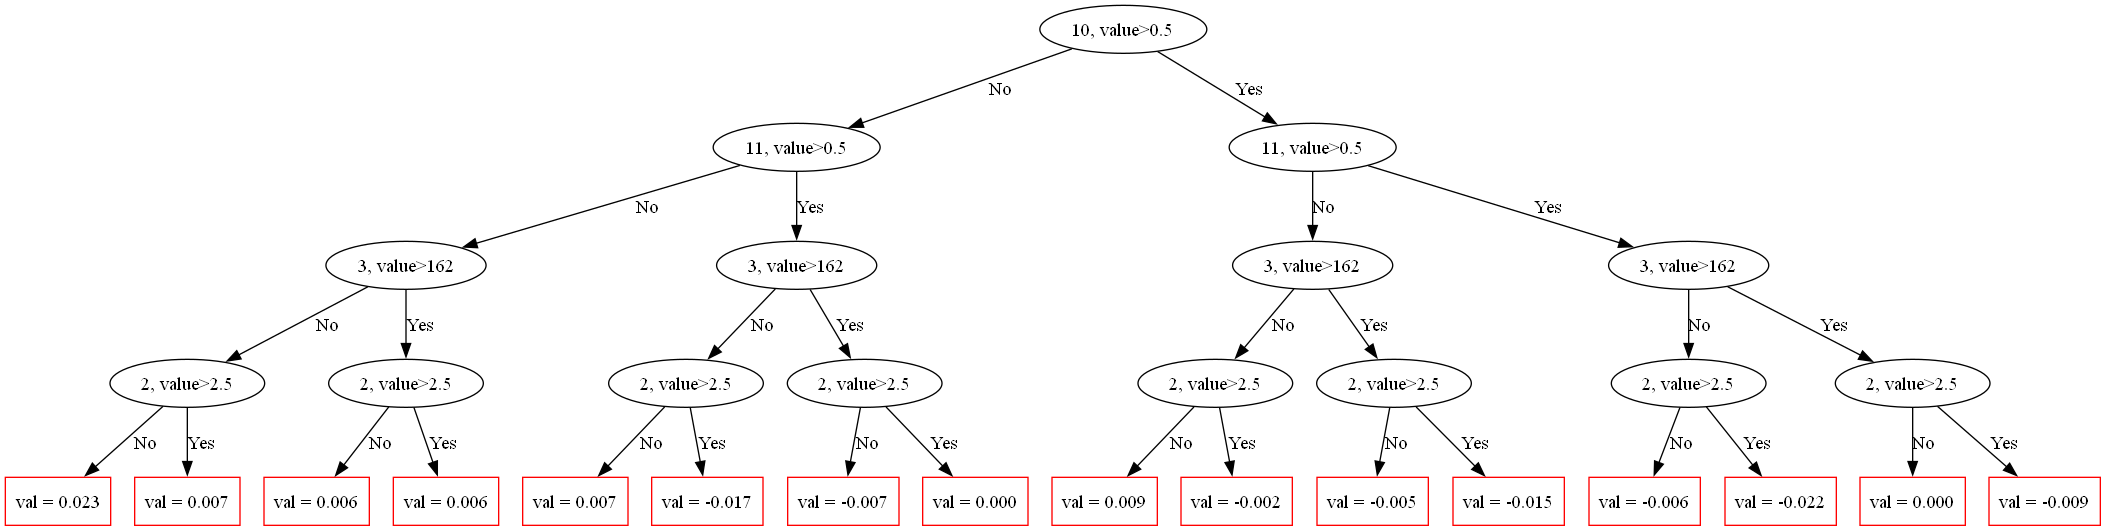

In [966]:
from IPython.display import Image
import graphviz

# 设定要可视化的树编号
tree_index = 66

# 获取 CatBoost 的 Graphviz Digraph 对象
graph = catboost_tuned.plot_tree(tree_idx=tree_index)

# 渲染为 PNG 图并保存
filename = f"catboost_tree_{tree_index}"
graph.render(filename=filename, format="png", cleanup=True)

# 在 Jupyter Notebook 中展示 PNG 图像
Image(filename=f"{filename}.png")
